# Network Analytics

Source: https://www.tapadhirdas.com/unr-idd-dataset

## Data Lineage

**- UNR_IDD**

For this Capstone project we are using data fron the University of Nevada.  Specifically, their Reno Intrusion Detection Dataset (UNR-IDD). The main difference between UNR-IDD and other existing datasets is that UNR-IDD consists primarily of network port statistics. These refer to the observed port metrics recorded in switch/router ports within a networking environment. The dataset also includes delta port statistics which indicates the change in magnitude of observed port statistics within a time interval. Compared to datasets that primarily use flow level statistics, these port statistics can provide a fine-grained analysis of network flows from the port level as decisions are made at the port level versus the flow level. This can lead to rapid identification of potential intrusions. UNR-IDD also address the limitation of the presence of tail classes. The dataset ensures that there are enough samples for ML classifiers to achieve high F-Measure scores, uniquely. Our proposed dataset also ensures that there are no missing network metrics and that all data samples are filled.

**- Flow Simulation**

IPerf is used to create TCP and UDP data streams simulating network flows in virtual and real networks using dummy payloads. By using the Mininet API and IPerf, UNR-IDD created a Python script to simulate realistic network flows. Once every 5 seconds, UNR-IDD initiated Iperf traffic between a randomly chosen source-destination host pair with a bandwidth of 10 Mbps and a duration of 5 seconds. UNR-IDD then simulate flows under normal and intrusion conditions to gather data in every possible scenario. To ensure that each normal and anomaly category is minimally variable and adequately represented, UNR-IDD execute the same number of flows while simulating each scenario.


**- Port Statistics**

The corresponding table shows the collected port statistics and their descriptions per port on every switch in the simulated SDN. These statistics relay the collected metrics and magnitudes from every single port within the SDN when a flow is simulated between two hosts. 


**- Port Statistic**|**Description**
---|---
Received Packets | Number of packets received by the port
Received Bytes |	Number of bytes received by the port
Sent Packets |	Number of packets sent by the port
Sent Bytes |	Number of bytes sent
Port alive | Duration	The time port has been alive in seconds
Packets Rx | Dropped	Number of packets dropped by the receiver
Packets Tx | Dropped	Number of packets dropped by the sender
Packets Rx | Errors	Number of transmit errors
Packets Tx | Errors	Number of receive errors



**- Delta Port Statistics**

The corresponding table illustrates the collected delta port statistics and their descriptions per port on every switch. These delta statistics are used to capture the change in collected metrics from every single port within the SDN when a flow is simulated between two hosts. The time interval for these observed metrics is configured as 5 seconds, which can provide greater detail in detecting intrusions. 


**- Delta Port Statistic**|**Description**
---|---
Delta Received Packets|	Number of packets received by the port
Delta Received Bytes|	Number of bytes received by the port
Delta Sent Packets|	Number of packets sent by the port
Delta Sent Bytes|	Number of bytes sent
Delta Port alive| Duration	The time port has been alive in seconds
Delta Packets Rx| Dropped	Number of packets dropped by the receiver
Delta Packets Tx| Dropped	Number of packets dropped by the sender
Delta Packets Rx| Errors	Number of transmit errors
Delta Packets Tx| Errors	Number of receive errors



**- Flow Entry and Flow Table Statistics**

Additionally, UNR-IDD also collect some flow entry and flow table statistics to work in conjunction with the collected port statistics as seen in the corresponding table. These metrics provide information about the conditions of switches in the network and can be collected in any network setting. 

**Statistic**|**Description**
---|---
Connection Point|	Network connection point expressed as a pair of the network element identifier and port number.
Total Load/Rate|	Obtain the current observed total load/rate (in bytes/s) on a link.
Total Load/Latest|	Obtain the latest total load bytes counter viewed on that link.
Unknown Load/Rate|	Obtain the current observed unknown-sized load/rate (in bytes/s) on a link.
Unknown Load/Latest|	Obtain the latest unknown-sized load bytes counter viewed on that link.
Time seen|	When the above-mentioned values were last seen.
is_valid|	Indicates whether this load was built on valid values.
TableID|	Returns the Table ID values.
ActiveFlowEntries|	Returns the number of active flow entries in this table.
PacketsLookedUp|	Returns the number of packets looked up in the table.
PacketsMatched|	Returns the number of packets that successfully matched in the table.
MaxSize|	Returns the maximum size of this table.




In [1]:
import pandas as pd
upload = pd.read_csv('../data/raw/UNR-IDD.csv')

In [4]:
!conda install TPOT

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - tpot

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# import tpot
import xgboost 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sns.color_palette()
# Warning
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.2f}".format

/home/barrocoeb/anaconda3/envs/networks/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Dataset

In [4]:
raw_df = upload

In [5]:
raw_df.head(5)

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37411 entries, 0 to 37410
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Switch ID                      37411 non-null  object
 1   Port Number                    37411 non-null  object
 2   Received Packets               37411 non-null  int64 
 3   Received Bytes                 37411 non-null  int64 
 4   Sent Bytes                     37411 non-null  int64 
 5   Sent Packets                   37411 non-null  int64 
 6   Port alive Duration (S)        37411 non-null  int64 
 7   Packets Rx Dropped             37411 non-null  int64 
 8   Packets Tx Dropped             37411 non-null  int64 
 9   Packets Rx Errors              37411 non-null  int64 
 10  Packets Tx Errors              37411 non-null  int64 
 11  Delta Received Packets         37411 non-null  int64 
 12  Delta Received Bytes           37411 non-null  int64 
 13  D

**Comment:** Continuous and discrete numerical variables, as well as categorical features.

In [8]:
# Checking for duplicates
raw_df[raw_df.duplicated() == True]

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
32287,of:000000000000000a,Port#:3,66,9078,8992,63,56,0,0,0,...,0,0,True,0,4,201,123,-1,PortScan,Attack


In [9]:
# drop duplicates
raw_df = raw_df.drop_duplicates()

In [10]:
# Checking for duplicates
raw_df[raw_df.duplicated() == True]

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label


In [11]:
# Missing values checking
pd.DataFrame(data={'% of Missing Values':round(raw_df.isna().sum()/raw_df.isna().count()*100,2)})

,% of Missing Values
Switch ID,0.00
Port Number,0.00
Received Packets,0.00
Received Bytes,0.00
Sent Bytes,0.00
Sent Packets,0.00
Port alive Duration (S),0.00
Packets Rx Dropped,0.00
Packets Tx Dropped,0.00
Packets Rx Errors,0.00


**No missing values**

In [11]:
# Converting object to categorical features
for i in raw_df:
  if raw_df[i].dtypes == 'object':
    raw_df[i] = raw_df[i].astype('category')

In [12]:
# Numerical columns
num_cols = list(raw_df._get_numeric_data().columns)
num_cols

['Received Packets',
 'Received Bytes',
 'Sent Bytes',
 'Sent Packets',
 'Port alive Duration (S)',
 'Packets Rx Dropped',
 'Packets Tx Dropped',
 'Packets Rx Errors',
 'Packets Tx Errors',
 'Delta Received Packets',
 'Delta Received Bytes',
 'Delta Sent Bytes',
 'Delta Sent Packets',
 'Delta Port alive Duration (S)',
 'Delta Packets Rx Dropped',
 ' Delta Packets Tx Dropped',
 'Delta Packets Rx Errors',
 'Delta Packets Tx Errors',
 'Connection Point',
 'Total Load/Rate',
 'Total Load/Latest',
 'Unknown Load/Rate',
 'Unknown Load/Latest',
 'Latest bytes counter',
 'is_valid',
 'Table ID',
 'Active Flow Entries',
 'Packets Looked Up',
 'Packets Matched',
 'Max Size']

In [13]:
num_cols = ['Received Packets',
 'Received Bytes',
 'Sent Bytes',
 'Sent Packets',
 'Port alive Duration (S)',
 'Packets Rx Dropped',
 'Packets Tx Dropped',
 'Packets Rx Errors',
 'Packets Tx Errors',
 'Delta Received Packets',
 'Delta Received Bytes',
 'Delta Sent Bytes',
 'Delta Sent Packets',
 'Delta Packets Rx Dropped',
 ' Delta Packets Tx Dropped',
 'Delta Packets Rx Errors',
 'Delta Packets Tx Errors',
 'Total Load/Rate',
 'Total Load/Latest',
 'Unknown Load/Rate',
 'Unknown Load/Latest',
 'Latest bytes counter',
 'is_valid',
 'Table ID',
 'Active Flow Entries',
 'Packets Looked Up',
 'Packets Matched',
 'Max Size']

In [14]:
# Categorical columns
cat_cols = ['Label', 'Binary Label', 'Switch ID', 'Port Number','Delta Port alive Duration (S)', 'Connection Point']


In [16]:
# Printing unique values
for i in cat_cols:
  print(f'{i}: {raw_df[i].nunique()}')

Label: 6
Binary Label: 2
Switch ID: 12
Port Number: 4
Delta Port alive Duration (S): 2
Connection Point: 5


In [17]:
# Printing unique values
for i in num_cols:
  print(f'{i}: {raw_df[i].nunique()}')

Received Packets: 9931
Received Bytes: 26044
Sent Bytes: 32456
Sent Packets: 11570
Port alive Duration (S): 1206
Packets Rx Dropped: 1
Packets Tx Dropped: 1
Packets Rx Errors: 1
Packets Tx Errors: 1
Delta Received Packets: 676
Delta Received Bytes: 3635
Delta Sent Bytes: 3476
Delta Sent Packets: 567
Delta Packets Rx Dropped: 1
 Delta Packets Tx Dropped: 1
Delta Packets Rx Errors: 1
Delta Packets Tx Errors: 1
Total Load/Rate: 1297
Total Load/Latest: 1918
Unknown Load/Rate: 1297
Unknown Load/Latest: 1918
Latest bytes counter: 1297
is_valid: 1
Table ID: 1
Active Flow Entries: 44
Packets Looked Up: 9311
Packets Matched: 9318
Max Size: 1


In [17]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Received Packets,37410.00,21619.47,65283.95,9.00,329.00,1170.00,3417.00,352772.00
Received Bytes,37410.00,26475617.27,37030682.73,786.00,91141.50,12630515.00,37832295.00,271592472.00
Sent Bytes,37410.00,24512775.63,34398987.20,5705.00,57803.50,12626588.00,31764531.50,239242994.00
Sent Packets,37410.00,33627.72,88793.99,41.00,347.00,1240.50,3968.00,421598.00
Port alive Duration (S),37410.00,911.12,982.12,26.00,136.00,260.00,1747.00,3317.00
Packets Rx Dropped,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Tx Dropped,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Rx Errors,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Tx Errors,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Delta Received Packets,37410.00,194.96,1087.15,0.00,2.00,4.00,6.00,15695.00


In [18]:
for column in cat_cols:
    print(raw_df[column].value_counts())
    print('-'*50)

PortScan     9499
TCP-SYN      9081
Blackhole    8420
Diversion    5615
Normal       3773
Overflow     1022
Name: Label, dtype: int64
--------------------------------------------------
Attack    33637
Normal     3773
Name: Binary Label, dtype: int64
--------------------------------------------------
of:000000000000000c    5490
of:000000000000000a    5096
of:0000000000000003    4910
of:0000000000000001    3780
of:0000000000000004    3386
of:0000000000000007    2620
of:000000000000000b    2476
of:0000000000000008    2208
of:0000000000000005    2056
of:0000000000000002    1884
of:0000000000000006    1752
of:0000000000000009    1752
Name: Switch ID, dtype: int64
--------------------------------------------------
Port#:1    11903
Port#:2    11846
Port#:3     8960
Port#:4     4701
Name: Port Number, dtype: int64
--------------------------------------------------
5    31534
4     5876
Name: Delta Port alive Duration (S), dtype: int64
--------------------------------------------------
2    111

## Exploratory Data Analysis

- Function: plotting numerical features

In [19]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(10,7), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='lightblue') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='blue', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Univariate analysis (continuous numerical)

In [20]:
num_cols_continuous = ['Received Packets', 'Received Bytes',  'Sent Bytes',
            'Sent Packets', 'Port alive Duration (S)', 'Delta Received Packets',
            'Delta Received Bytes', 'Delta Sent Packets', 'Delta Sent Bytes',
            'Total Load/Rate', 'Total Load/Latest', 'Unknown Load/Rate',
            'Unknown Load/Latest', 'Latest bytes counter', 'Active Flow Entries',
            'Packets Looked Up', 'Packets Matched']

In [21]:
# Mean, Median and Mode
for i in num_cols_continuous:
    mean=raw_df[i].mean()
    median=raw_df[i].median()
    mode=raw_df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Received Packets, Mean: 21619.473295910186, Median: 1170.0, Mode: 132
Feature: Received Bytes, Mean: 26475617.26516974, Median: 12630515.0, Mode: 9181
Feature: Sent Bytes, Mean: 24512775.627746593, Median: 12626588.0, Mode: 6311853
Feature: Sent Packets, Mean: 33627.72119754076, Median: 1240.5, Mode: 238
Feature: Port alive Duration (S), Mean: 911.1192729216787, Median: 260.0, Mode: 46
Feature: Delta Received Packets, Mean: 194.96319165998395, Median: 4.0, Mode: 0
Feature: Delta Received Bytes, Mean: 342709.22638331994, Median: 556.0, Mode: 0
Feature: Delta Sent Packets, Mean: 178.08791766907245, Median: 4.0, Mode: 2
Feature: Delta Sent Bytes, Mean: 314520.95797914994, Median: 556.0, Mode: 280
Feature: Total Load/Rate, Mean: 19215.06498262497, Median: 0.0, Mode: 0
Feature: Total Load/Latest, Mean: 514573.41702753276, Median: 0.0, Mode: 0
Feature: Unknown Load/Rate, Mean: 19215.06498262497, Median: 0.0, Mode: 0
Feature: Unknown Load/Latest, Mean: 514573.41702753276, Median: 0.0

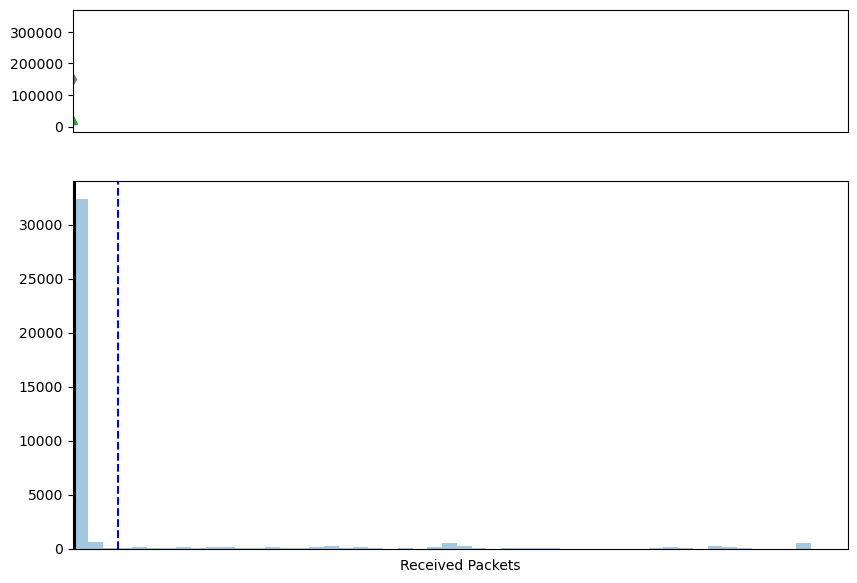

In [22]:
# Numerical continous analysis
histogram_boxplot(raw_df['Received Packets'])

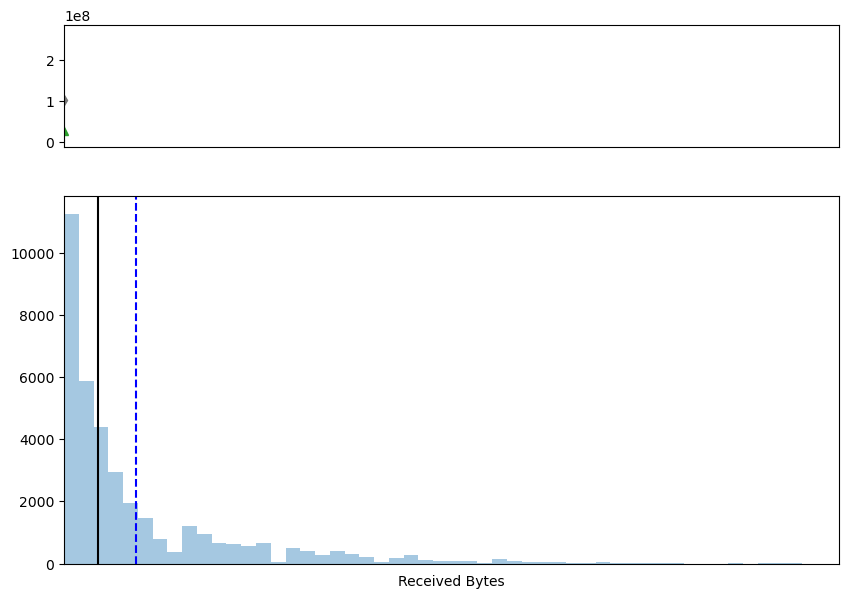

In [23]:
histogram_boxplot(raw_df['Received Bytes'])

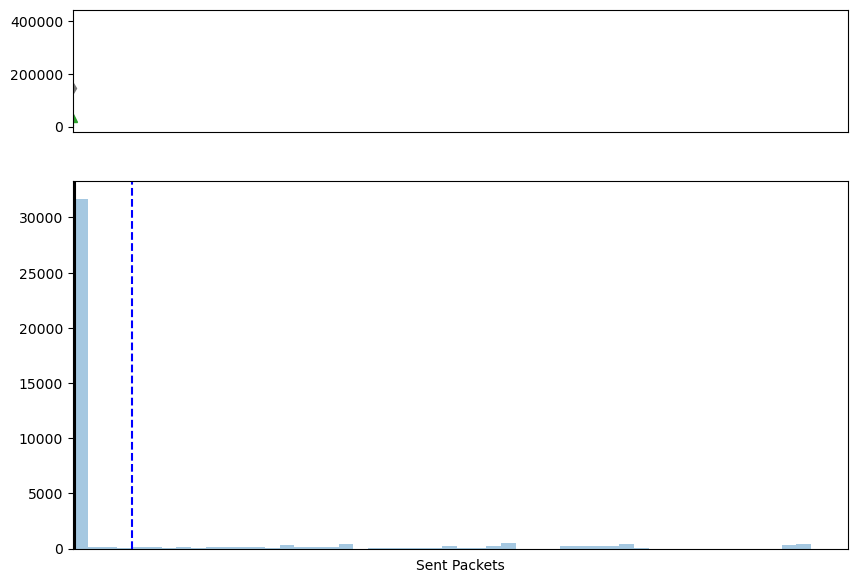

In [24]:
histogram_boxplot(raw_df['Sent Packets'])

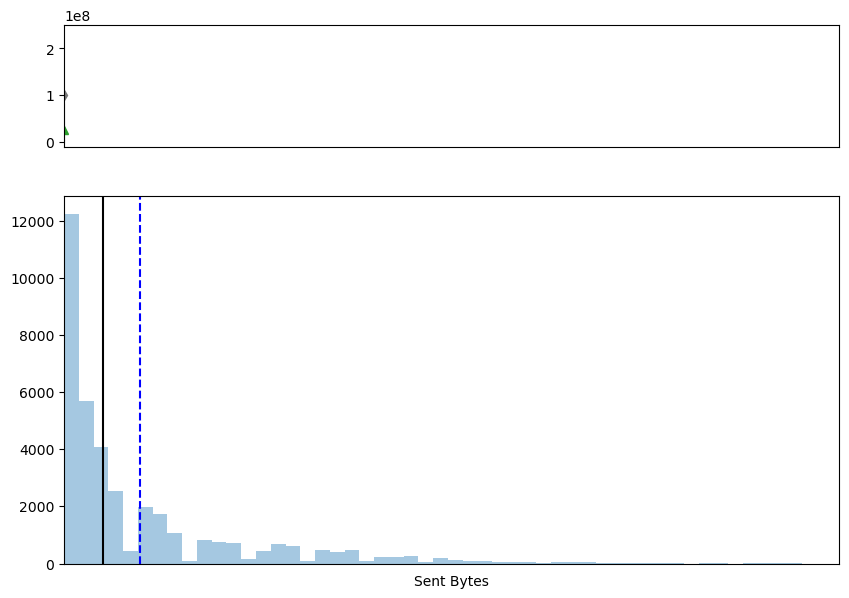

In [25]:
histogram_boxplot(raw_df['Sent Bytes'])

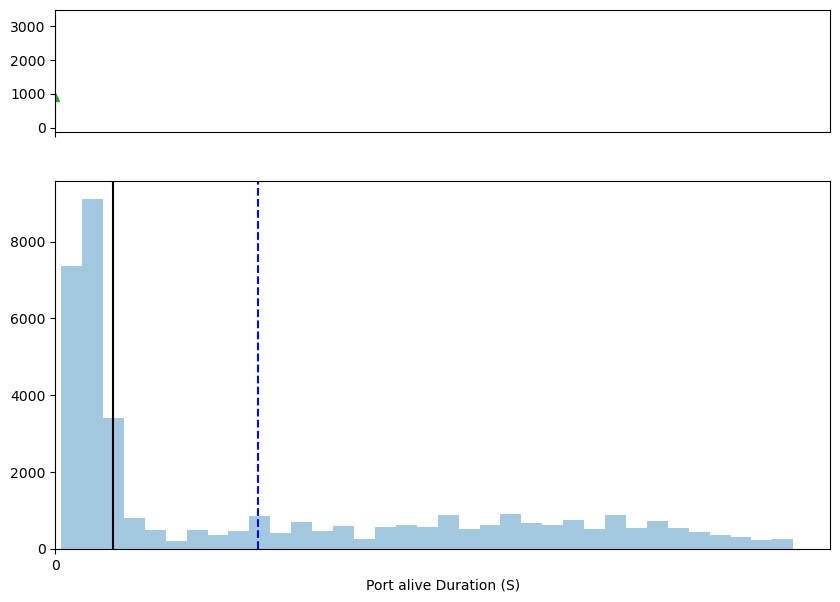

In [26]:
histogram_boxplot(raw_df['Port alive Duration (S)'])

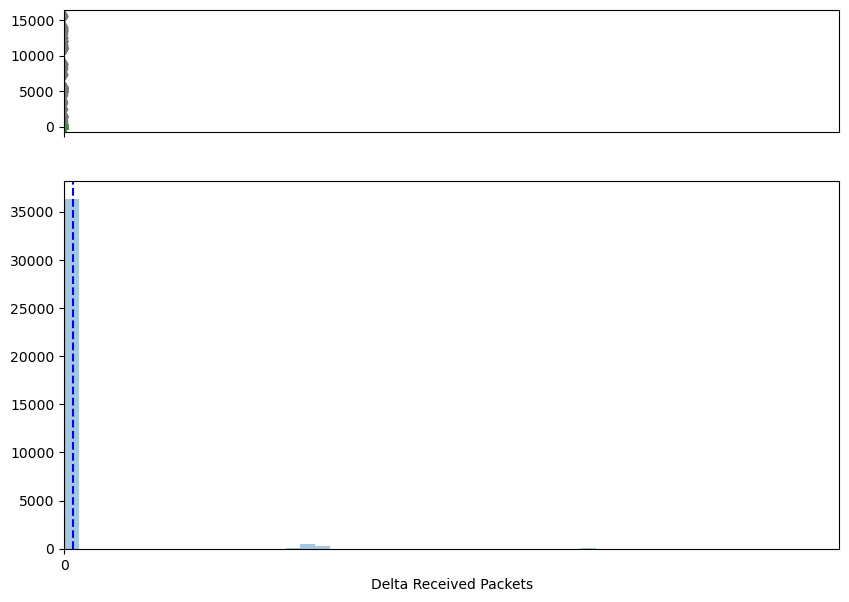

In [27]:
histogram_boxplot(raw_df['Delta Received Packets'])

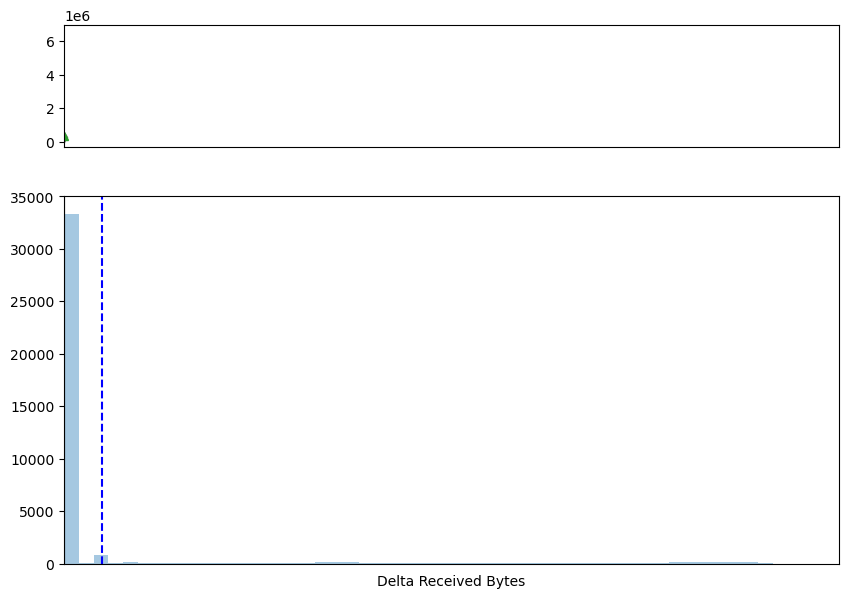

In [28]:
histogram_boxplot(raw_df['Delta Received Bytes'])

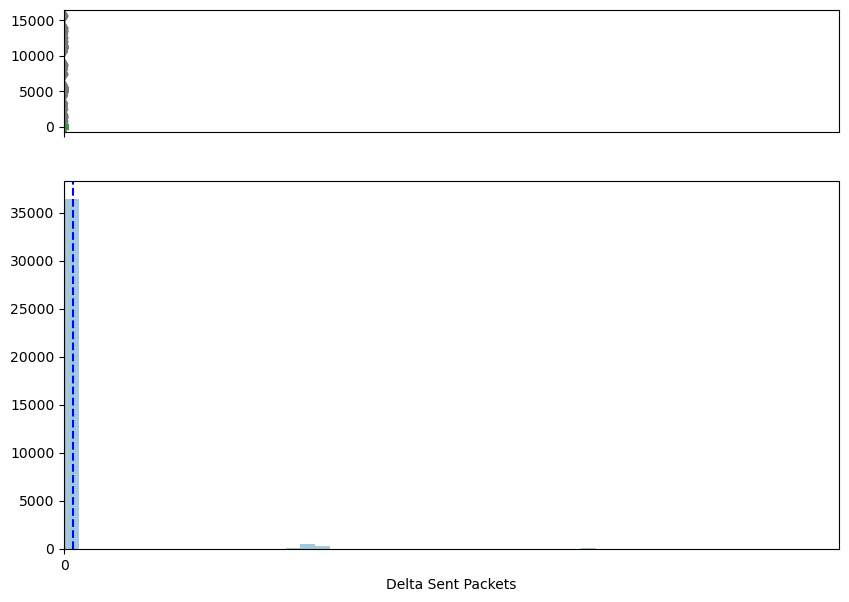

In [29]:
histogram_boxplot(raw_df['Delta Sent Packets'])

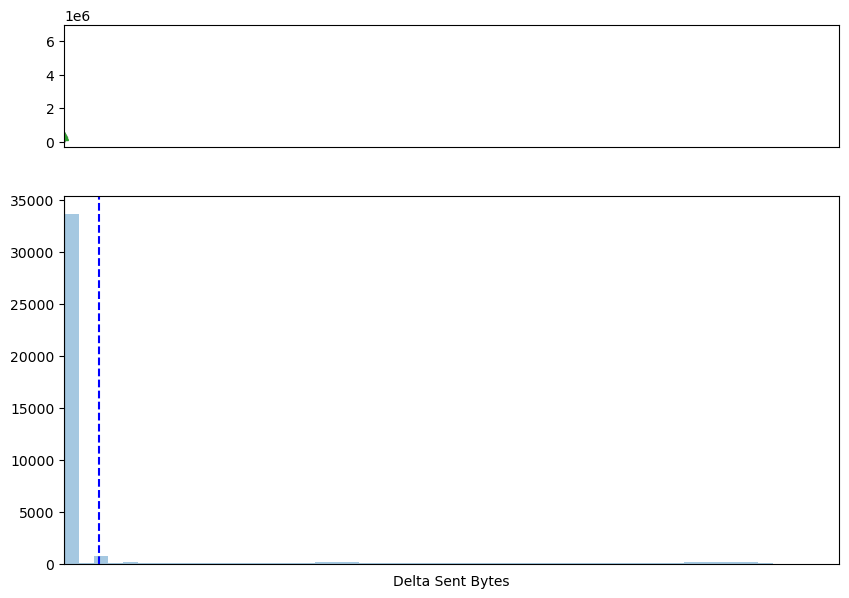

In [30]:
histogram_boxplot(raw_df['Delta Sent Bytes'])

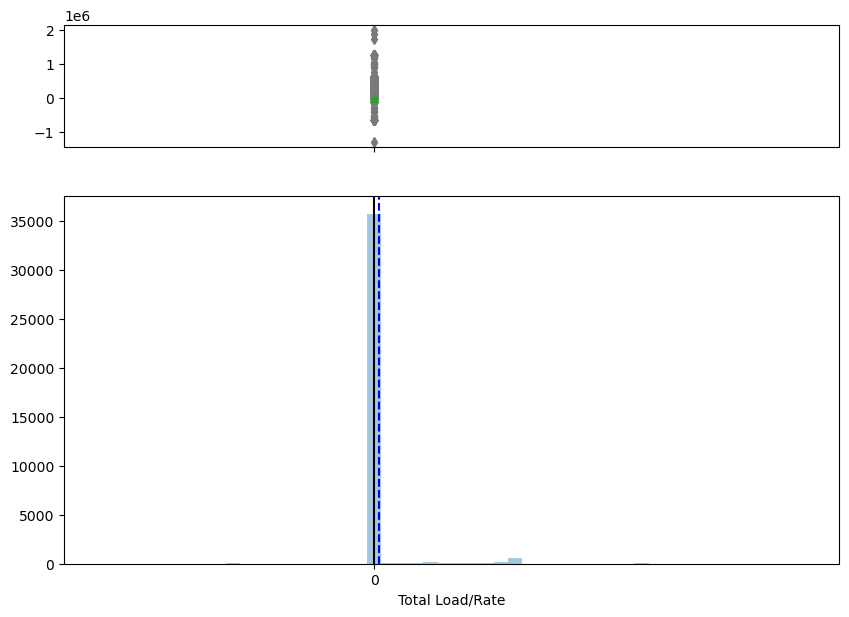

In [31]:
histogram_boxplot(raw_df['Total Load/Rate'])

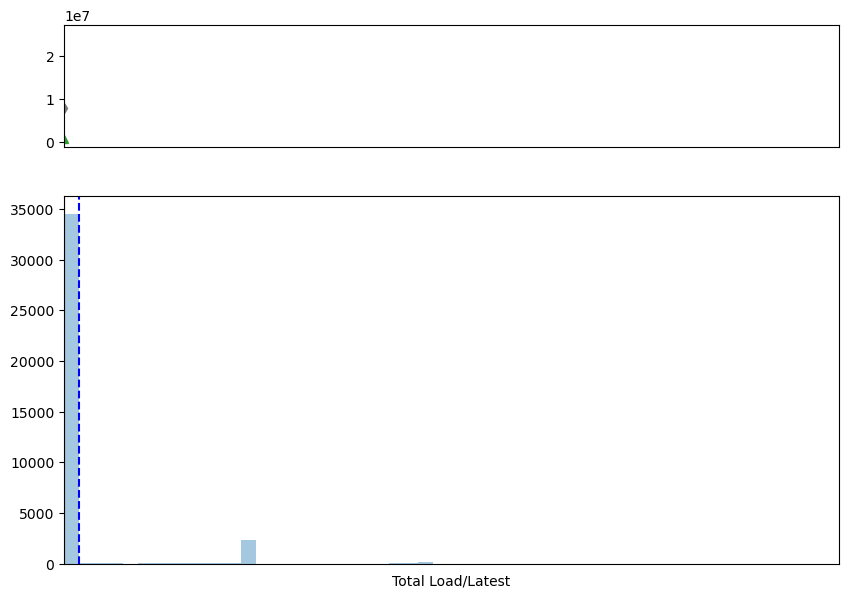

In [32]:
histogram_boxplot(raw_df['Total Load/Latest'])

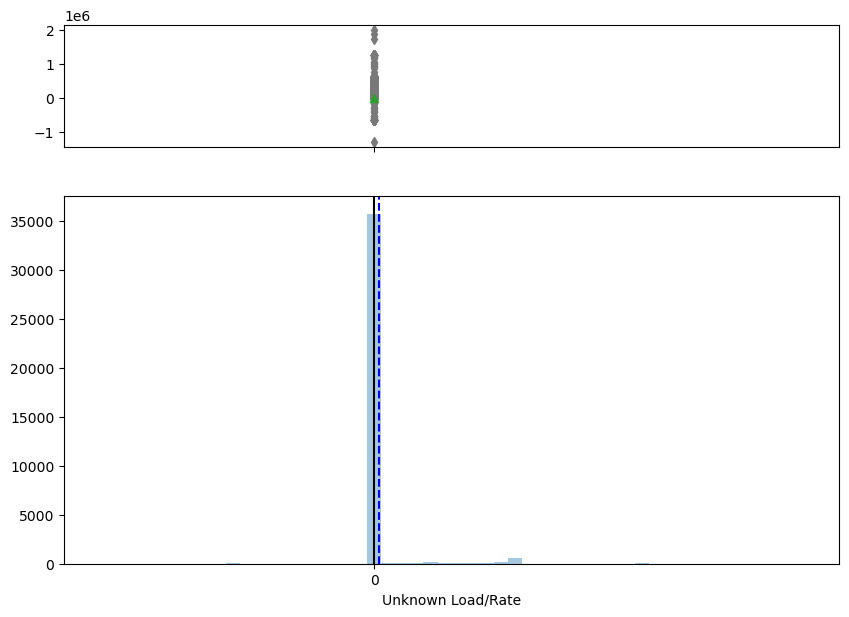

In [33]:
histogram_boxplot(raw_df['Unknown Load/Rate'])

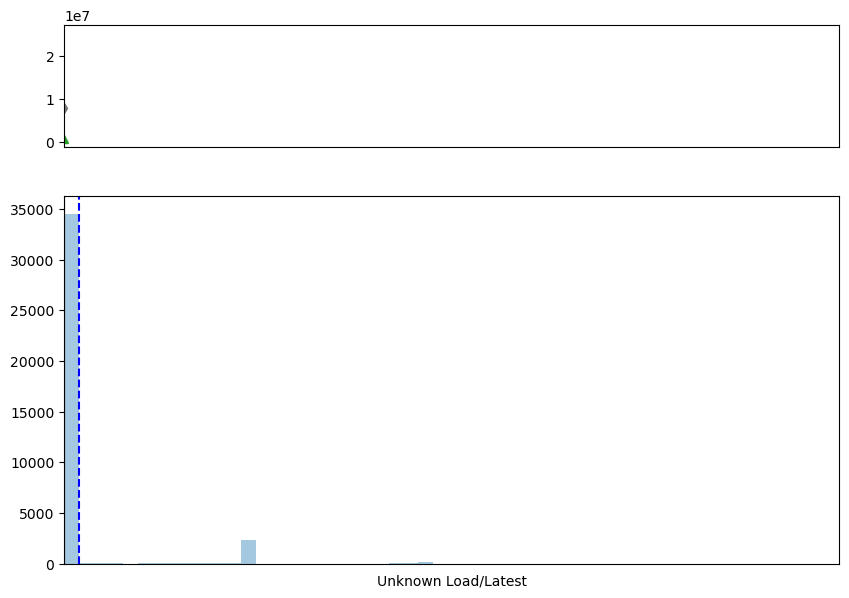

In [34]:
histogram_boxplot(raw_df['Unknown Load/Latest'])

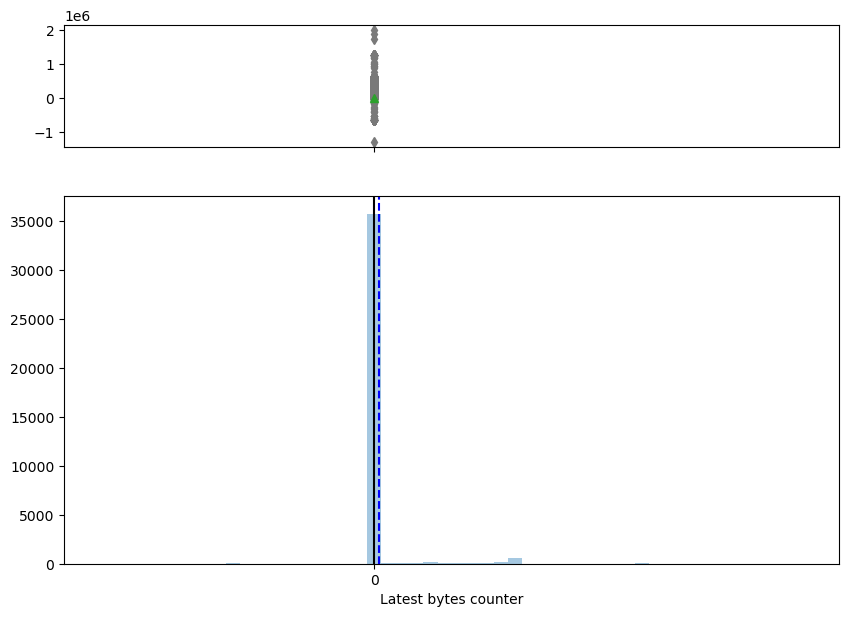

In [35]:
histogram_boxplot(raw_df['Latest bytes counter'])

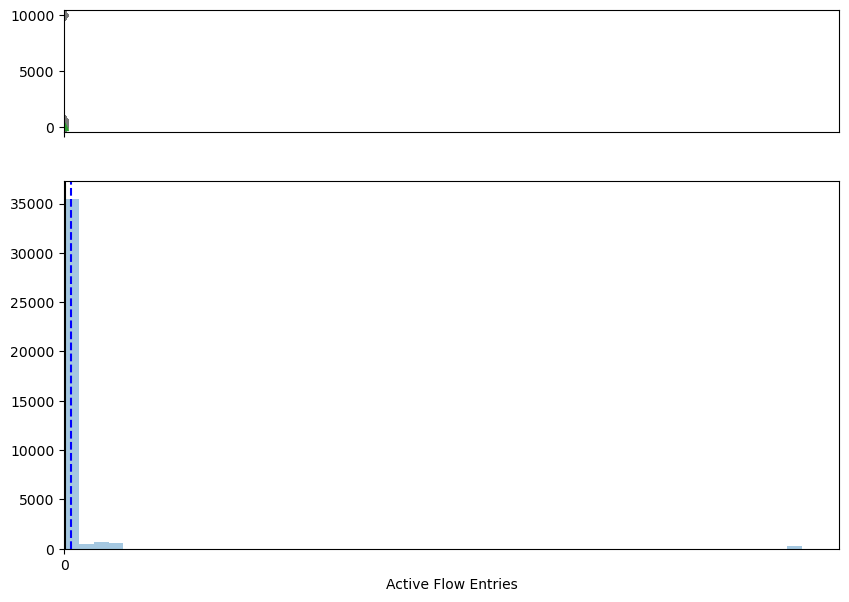

In [36]:
histogram_boxplot(raw_df['Active Flow Entries'])

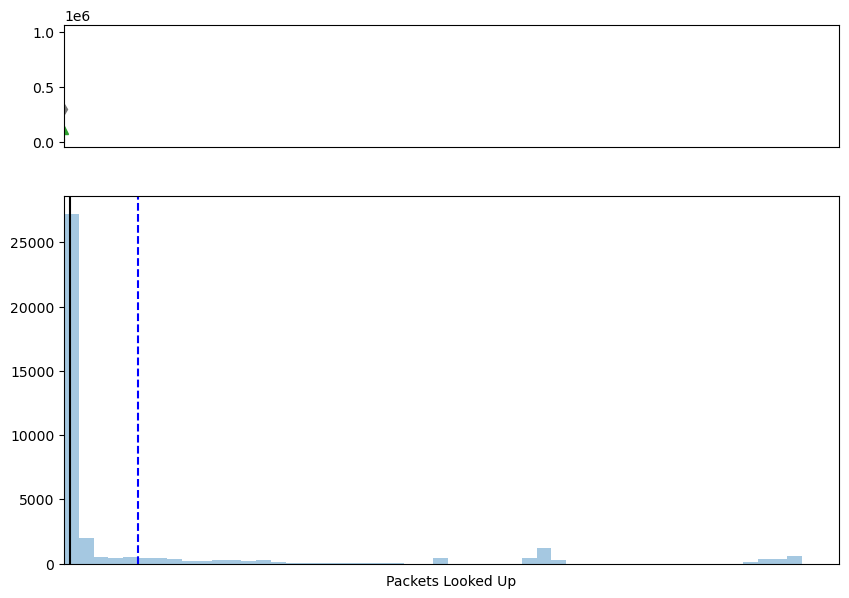

In [39]:
histogram_boxplot(raw_df['Packets Looked Up'])

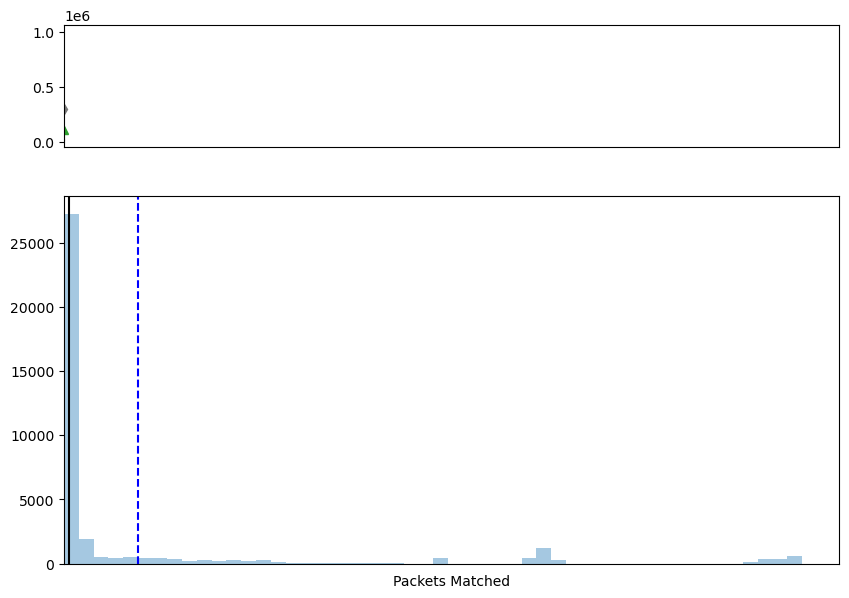

In [40]:
histogram_boxplot(raw_df['Packets Matched'])

### Univariate analysis (discrete numerical)

In [41]:
# Numerical discrete columns
num_cols_discrete = list(set(num_cols) - set(num_cols_continuous))
num_cols_discrete

['Packets Rx Dropped',
 'Delta Packets Tx Errors',
 'is_valid',
 'Delta Packets Rx Dropped',
 'Table ID',
 ' Delta Packets Tx Dropped',
 'Packets Rx Errors',
 'Packets Tx Errors',
 'Delta Packets Rx Errors',
 'Max Size',
 'Packets Tx Dropped']

In [42]:
# Mean, Median and Mode
for i in num_cols_discrete:
    mean=raw_df[i].mean()
    median=raw_df[i].median()
    mode=raw_df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Packets Rx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Delta Packets Tx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: is_valid, Mean: 1.0, Median: 1.0, Mode: True
Feature: Delta Packets Rx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Table ID, Mean: 0.0, Median: 0.0, Mode: 0
Feature:  Delta Packets Tx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Packets Rx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Packets Tx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Delta Packets Rx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Max Size, Mean: -1.0, Median: -1.0, Mode: -1
Feature: Packets Tx Dropped, Mean: 0.0, Median: 0.0, Mode: 0


**Comments:** We will probably drop all these features 

### Univariate analysis (categorical features)

- Function: plotting categorical features

In [43]:
# Function to create barplots that indicate percentage for each category.
def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

In [44]:
cat_cols

['Label',
 'Binary Label',
 'Switch ID',
 'Port Number',
 'Delta Port alive Duration (S)',
 'Connection Point']

In [45]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Label'],palette='summer')
perc_on_bar(ax,raw_df['Label'])

ValueError: could not convert string to float: 'TCP-SYN'

<Figure size 2000x500 with 0 Axes>

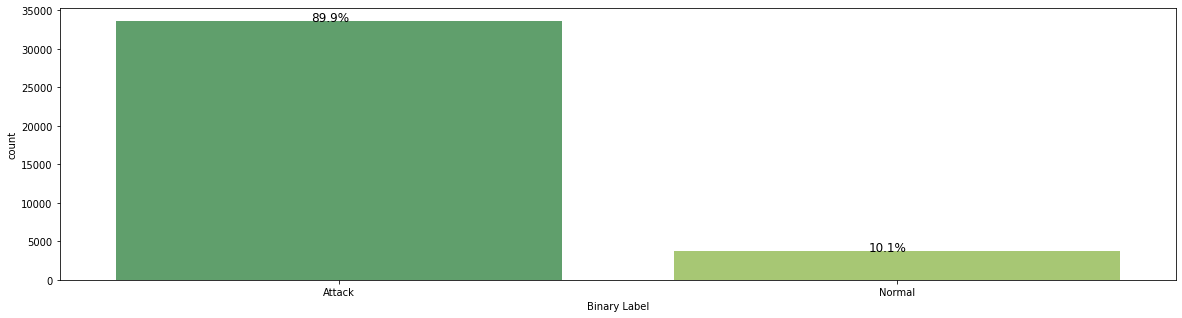

In [ ]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Binary Label'],palette='summer')
perc_on_bar(ax,raw_df['Binary Label'])

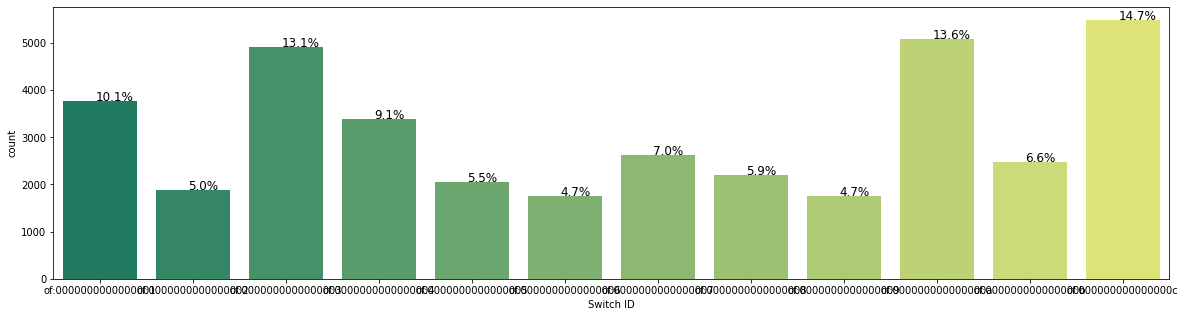

In [ ]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Switch ID'],palette='summer')
perc_on_bar(ax,raw_df['Switch ID'])

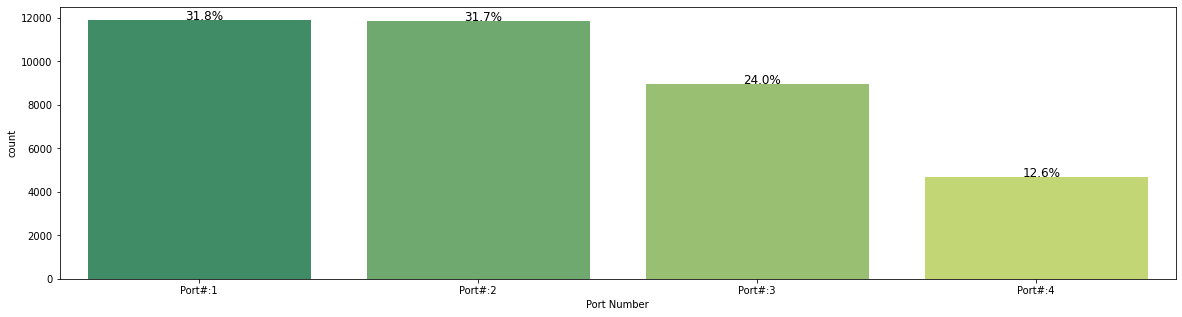

In [ ]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Port Number'],palette='summer')
perc_on_bar(ax,raw_df['Port Number'])

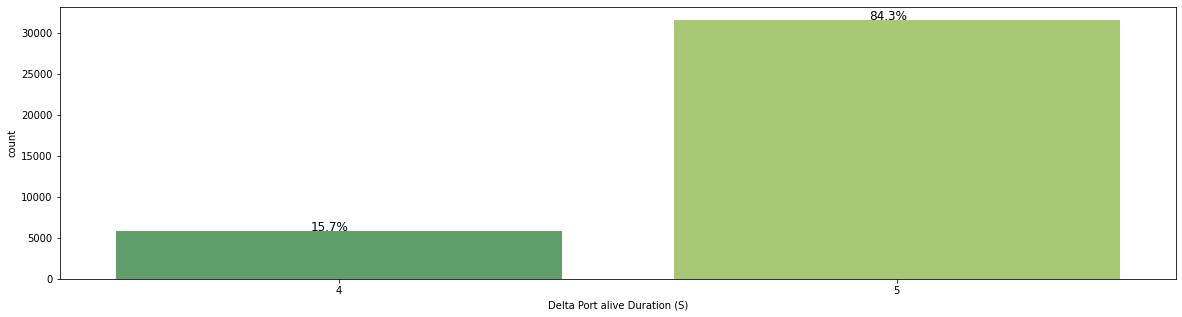

In [ ]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Delta Port alive Duration (S)'],palette='summer')
perc_on_bar(ax,raw_df['Delta Port alive Duration (S)'])

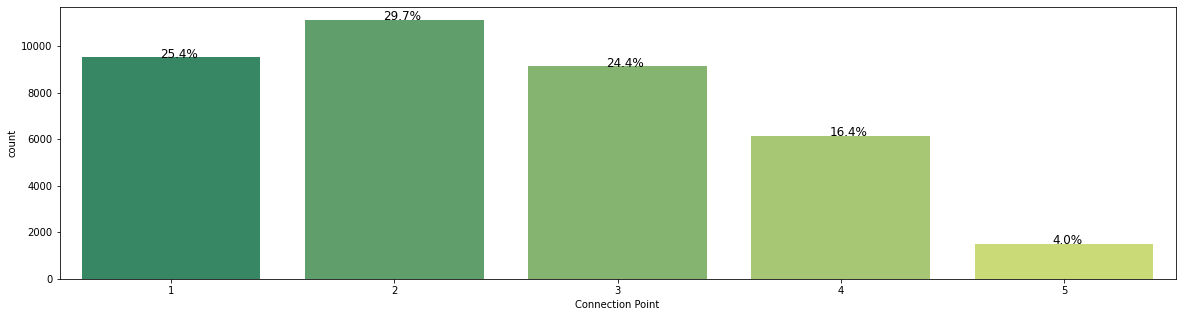

In [ ]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Connection Point'],palette='summer')
perc_on_bar(ax,raw_df['Connection Point'])

### Bivariate analysis (categorical features)

In [ ]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,raw_df["Label"],margins=True)
    print(tab1)
    print('-'*120)
    tab2 = pd.crosstab(x,raw_df["Label"],margins=True, normalize="index")
    print(tab2)
    print('-'*120)
    tab = pd.crosstab(x,raw_df["Label"],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(15,4))
    total = len(x) # length of the column
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
cat_cols

['Label',
 'Binary Label',
 'Switch ID',
 'Port Number',
 'Delta Port alive Duration (S)',
 'Connection Point']

Label        Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN    All
Port Number                                                                  
Port#:1           2680       1792    1179       375      3000     2877  11903
Port#:2           2680       1792    1179       321      3000     2874  11846
Port#:3           2100       1115     709       207      2499     2330   8960
Port#:4            960        916     706       119      1000     1000   4701
All               8420       5615    3773      1022      9499     9081  37410
------------------------------------------------------------------------------------------------------------------------
Label        Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN
Port Number                                                           
Port#:1           0.23       0.15    0.10      0.03      0.25     0.24
Port#:2           0.23       0.15    0.10      0.03      0.25     0.24
Port#:3           0.23       0.12    0.08      0.

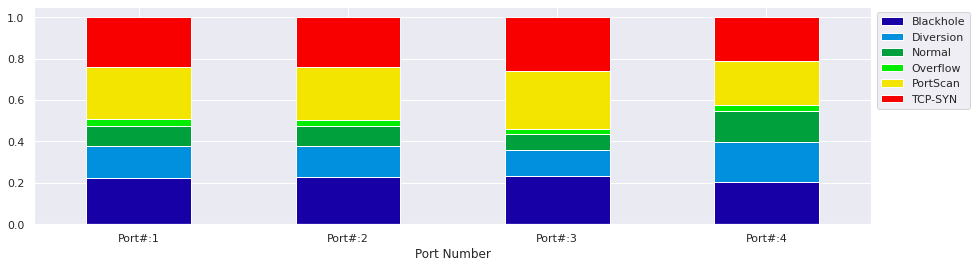

In [ ]:
stacked_plot(raw_df['Port Number'])

In [46]:
stacked_plot(raw_df['Switch ID'])

NameError: name 'stacked_plot' is not defined

In [47]:
stacked_plot(raw_df['Delta Port alive Duration (S)'])

NameError: name 'stacked_plot' is not defined

Label             Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN  \
Connection Point                                                              
1                      2480          0     943       220      3000     2874   
2                      2540       1593    1177       282      2921     2611   
3                      1720       1752     707       205      2499     2248   
4                      1680       1354     942       255       829     1089   
5                         0        916       4        60       250      259   
All                    8420       5615    3773      1022      9499     9081   

Label               All  
Connection Point         
1                  9517  
2                 11124  
3                  9131  
4                  6149  
5                  1489  
All               37410  
------------------------------------------------------------------------------------------------------------------------
Label             Blackhole  Diversion

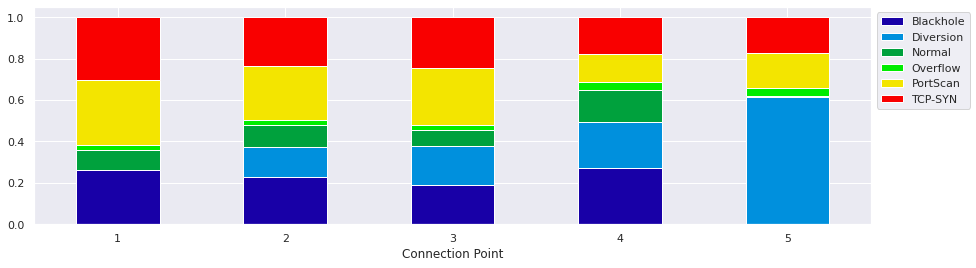

In [ ]:
stacked_plot(raw_df['Connection Point'])

### Bivariate Analysis

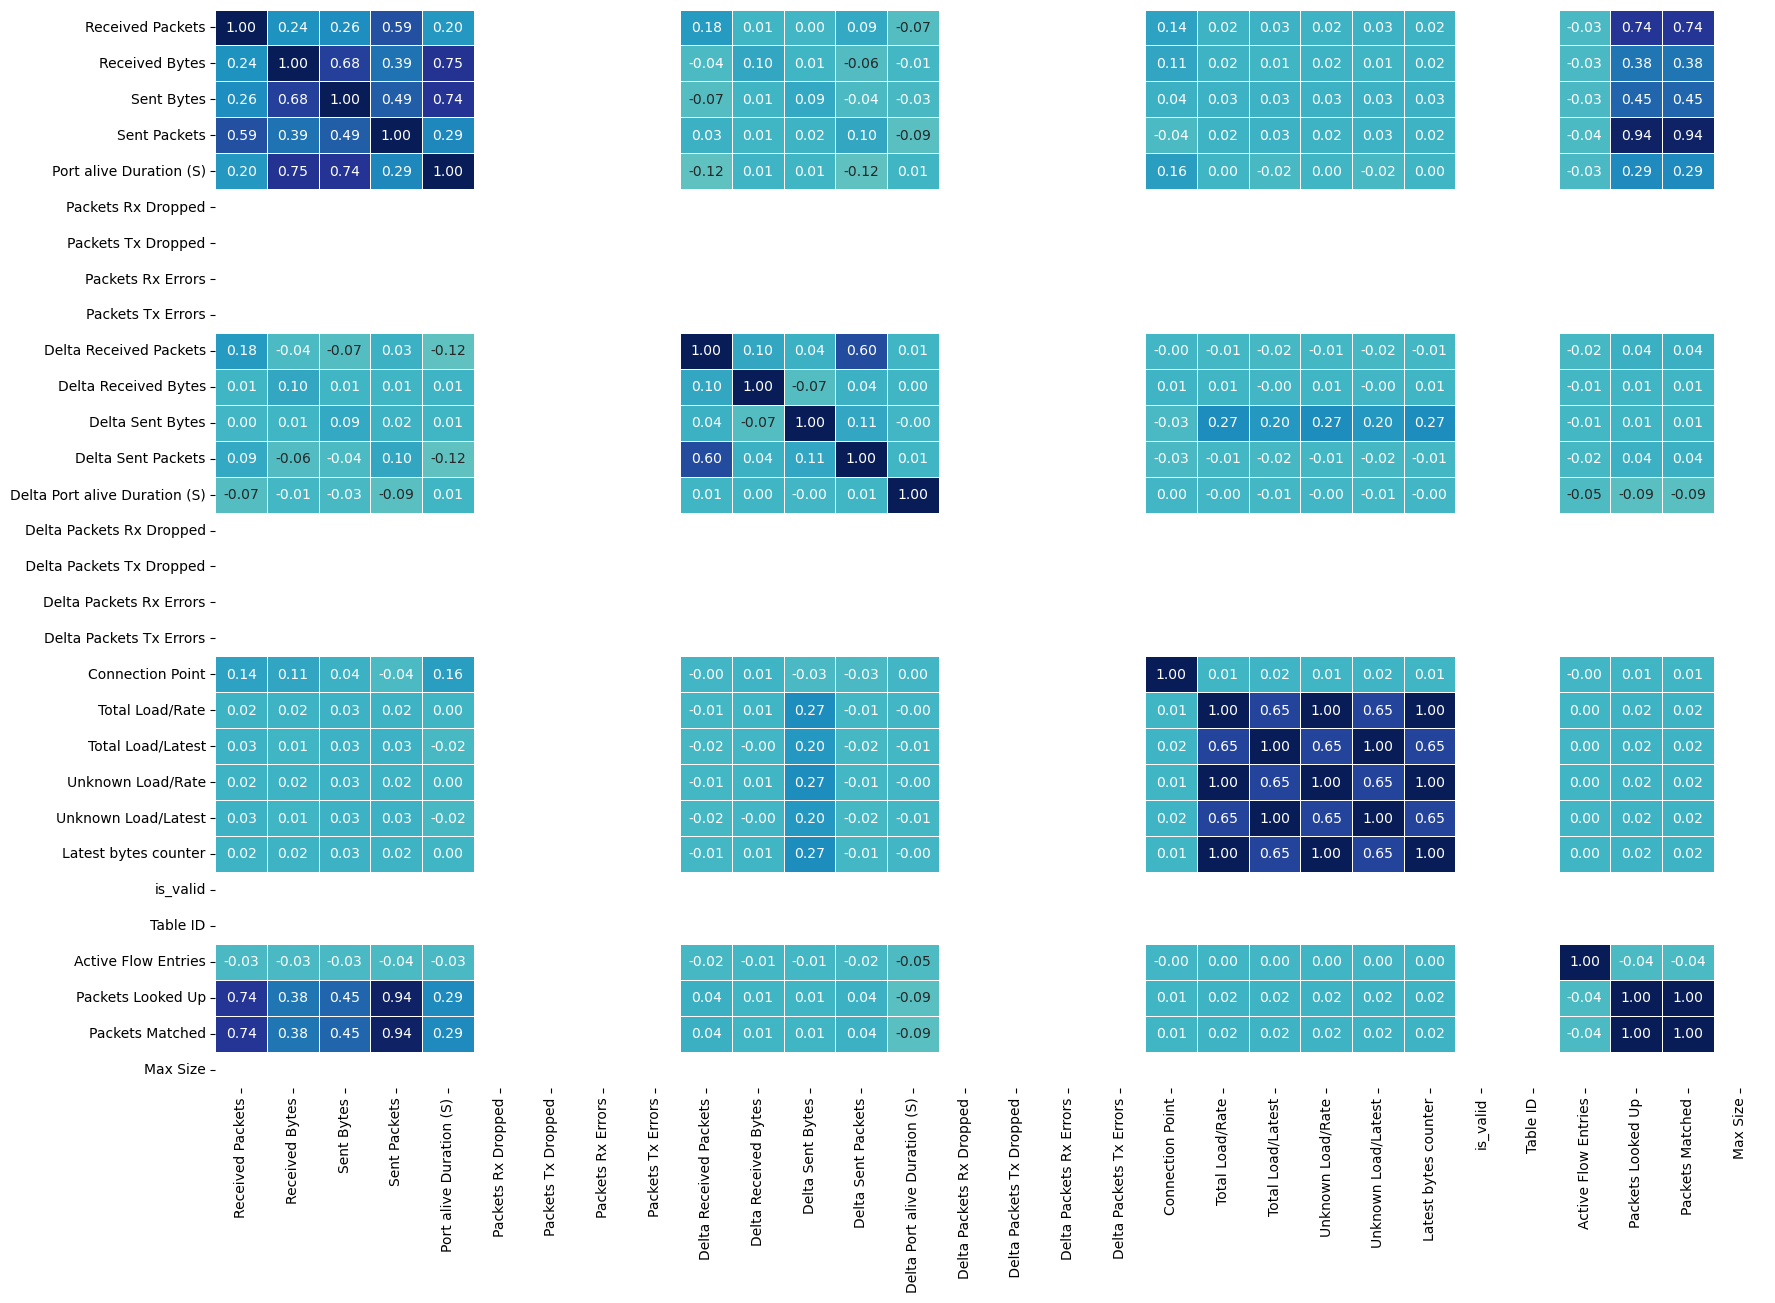

In [48]:
plt.figure(figsize=(20,14))

sns.heatmap(raw_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')            

plt.show()

**Comment:** Here we can see plenty of opportunity to drop features that won't impact much on our analysis. Some of them inclusive are filled with only zeros.


In [49]:
raw_df.columns

Index(['Switch ID', 'Port Number', 'Received Packets', 'Received Bytes',
       'Sent Bytes', 'Sent Packets', 'Port alive Duration (S)',
       'Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors',
       'Packets Tx Errors', 'Delta Received Packets', 'Delta Received Bytes',
       'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Delta Packets Rx Dropped',
       ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors',
       'Delta Packets Tx Errors', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest',
       'Latest bytes counter', 'is_valid', 'Table ID', 'Active Flow Entries',
       'Packets Looked Up', 'Packets Matched', 'Max Size', 'Label',
       'Binary Label'],
      dtype='object')

In [50]:
cleanned_df = raw_df[['Switch ID',
                     'Port Number',
                     'Received Packets',
                     'Received Bytes',
                     'Sent Bytes',
                     'Sent Packets',
                     'Port alive Duration (S)',
                     'Delta Received Packets',
                     'Delta Received Bytes',
                     'Delta Sent Bytes',
                     'Delta Sent Packets',
                     'Delta Port alive Duration (S)',
                     'Connection Point',
                     'Total Load/Rate',
                     'Total Load/Latest',
                     'Active Flow Entries',
                     'Label',
                     'Binary Label']]

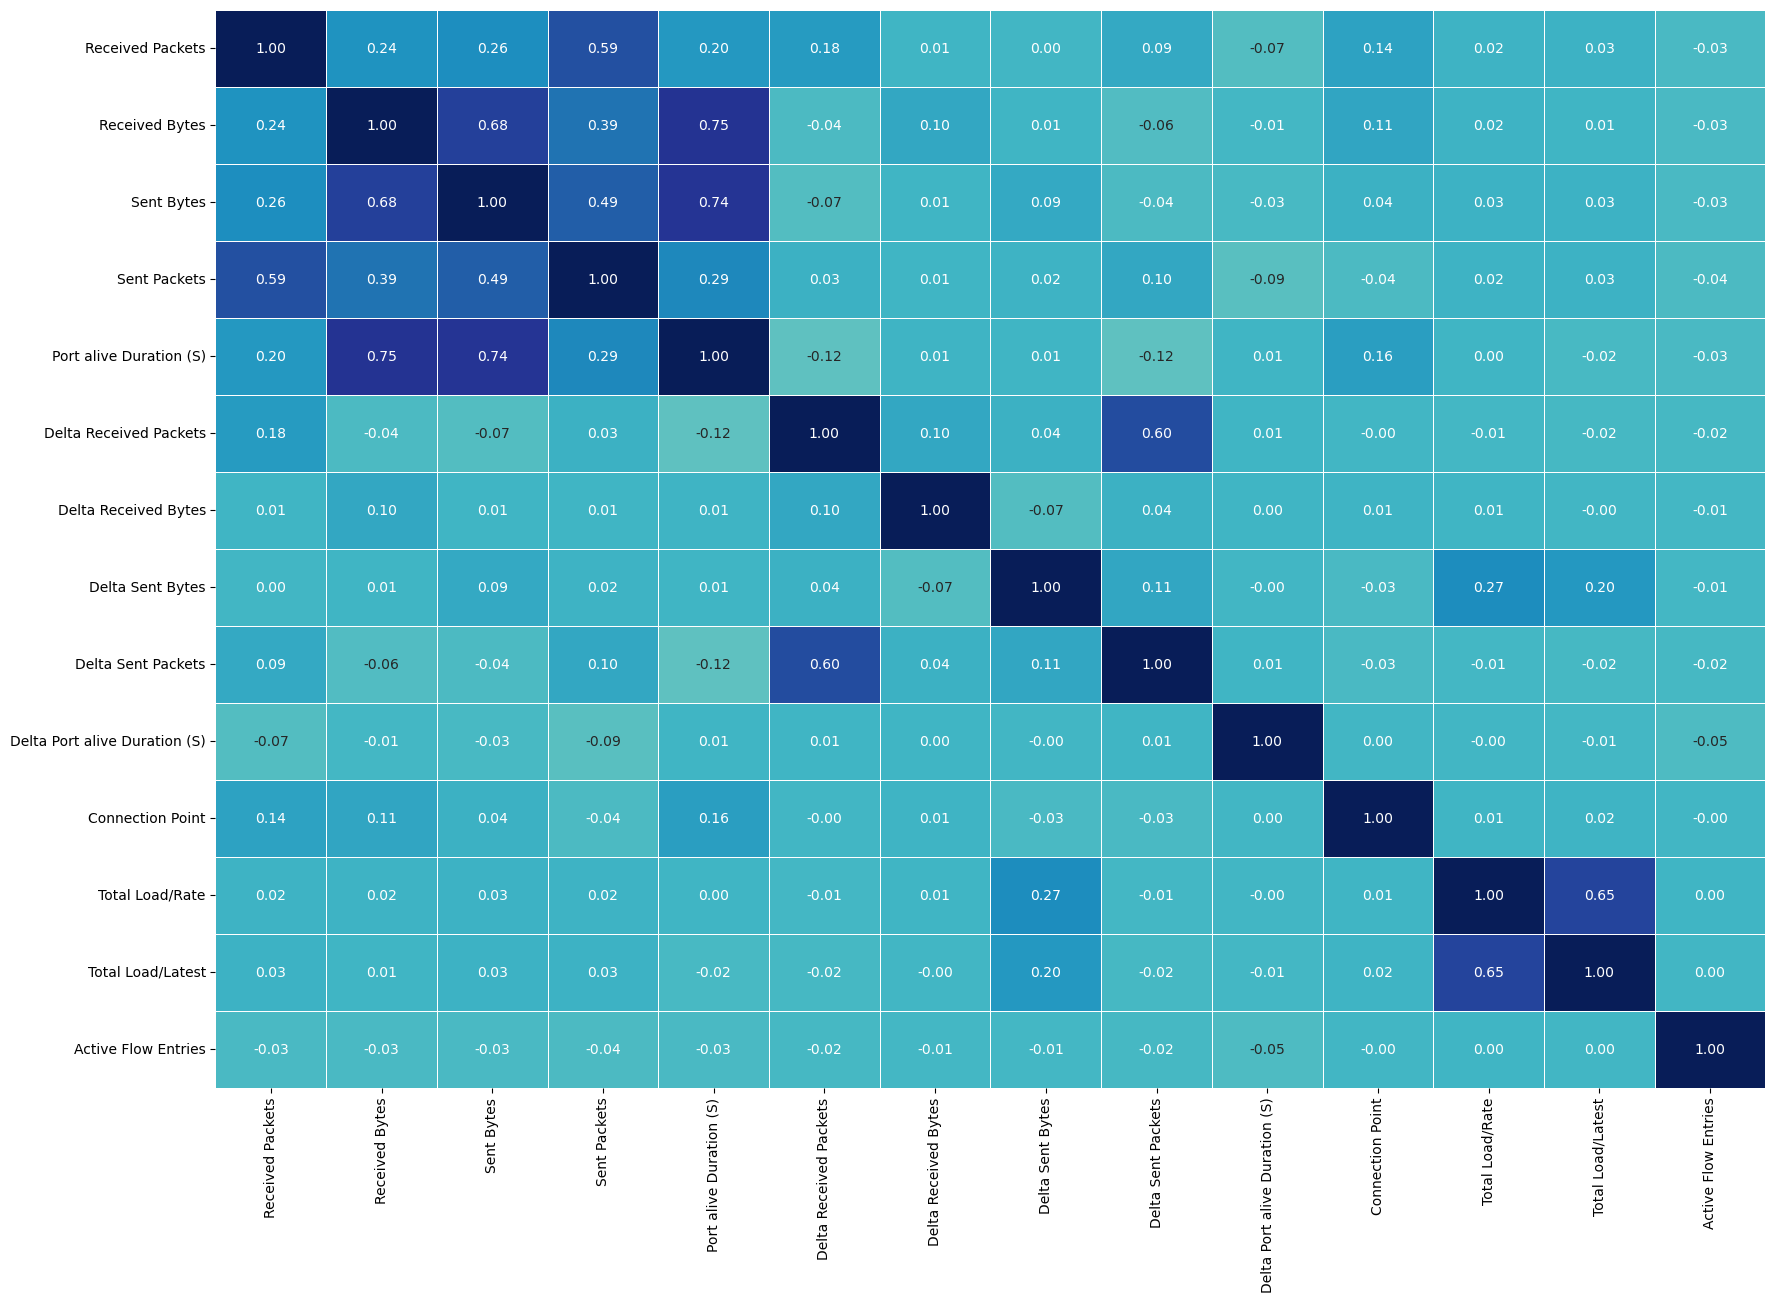

In [51]:
plt.figure(figsize=(20,14))

sns.heatmap(cleanned_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')            

plt.show()

In [52]:
from scipy import stats
# Applying Chi-Square test over target feature Attition_Flag
for i in cat_cols:  
  crosstab = pd.crosstab(raw_df['Label'],raw_df[i])  

  Ho = "ProdTaken has --NO-- effect on " + i   # Stating the Null Hypothesis
  Ha = "ProdTaken has an effect on " + i   # Stating the Alternate Hypothesis

  chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)

  if p_value < 0.05:  # Setting our significance level at 5%
      print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
  else:
      print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

ProdTaken has an effect on Label as the p_value (0.0) < 0.05
ProdTaken has an effect on Binary Label as the p_value (0.0) < 0.05
ProdTaken has an effect on Switch ID as the p_value (0.0) < 0.05
ProdTaken has an effect on Port Number as the p_value (0.0) < 0.05
ProdTaken has an effect on Delta Port alive Duration (S) as the p_value (0.0) < 0.05
ProdTaken has an effect on Connection Point as the p_value (0.0) < 0.05


In [53]:
# Saving data prior to Preparation
df_saved = cleanned_df.copy()

In [54]:
# Preprocessing dataFrame
df_start = df_saved.copy()

In [55]:
df_start.to_csv('../data/cleanned/cleanned.csv', index=False)

## Data Pre-processing

- Prepare the data for analysis
- Missing value treatment
- Outlier detection
- Feature Engineering
- Prepare data for modeling

In [56]:
# X has features but not target value
X_prep = df_start.drop(['Binary Label', 'Label'], axis=1)


# y only has target value
y_prep = df_start['Label']

In [57]:
# Transforming categorical features into dummies variables
X_prep_cat = pd.get_dummies(X_prep, drop_first=True)

In [58]:
# Label encoding target feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_prep = le.fit_transform(y_prep)

In [59]:
y_prep

array([5, 5, 5, ..., 4, 4, 4])

In [60]:
print(X_prep_cat.shape)
print(y_prep.shape)

(37410, 28)
(37410,)


In [61]:
# Saving dataset prior to treat for outliers
X_saved = X_prep_cat
y_saved = y_prep

### Outliers Treatment


In [62]:
from sklearn.ensemble import IsolationForest

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_prep_cat)

# Once identified, we can remove the outliers from the training dataset
# select all rows that are not outliers
mask = yhat != -1

X_lr_cat, y_lr = X_prep_cat[mask], y_prep[mask]

# summarize the shape of the updated training dataset
print(X_prep_cat.shape, y_prep.shape)

(37410, 28) (37410,)


##### Moment of splitting

In [78]:
# y_prep_cat = pd.DataFrame(y_prep)

In [63]:
# First split in Train (0.80) vs. Test (0.20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep_cat, y_prep, test_size=0.2, stratify=y_prep, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [85]:
# From numpy.array to pd.Series
# y_prep = pd.Series(y_prep)

* Label column not that imbalanced

In [64]:
print(type(y_train))
print(type(X_train))
print(type(y_test))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [88]:
# train_features = X_train
# train_label = pd.DataFrame(y_train)
# test_features = X_test
# test_label = pd.DataFrame(y_test)

# print(type(train_label))
# print(type(train_features))
# print(type(test_label))
# print(type(test_features))

# print(train_features.shape)
# print(train_label.shape)
# print(test_features.shape)
# print(test_label.shape)

#### Using TPOT to find best model for Label;

In [91]:
# %%time

# from tpot import TPOTClassifier
# tpot = TPOTClassifier(generations=5, 
#                       population_size=8,
#                       scoring=None,
#                       verbosity=2,
#                       random_state=42)
# tpot.fit(train_features, train_label)
# print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
# tpot.export('model.py')

Optimization Progress:   0%|          | 0/48 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8802127780931155

Generation 2 - Current best internal CV score: 0.9165490897512217

Generation 3 - Current best internal CV score: 0.9165490897512217

Generation 4 - Current best internal CV score: 0.9165490897512217

Generation 5 - Current best internal CV score: 0.9174904877272162

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=9, n_estimators=100)
Tpop score on test data: 0.93
CPU times: user 45min 33s, sys: 31.8 s, total: 46min 5s
Wall time: 45min 32s


### Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)

#### Tpop score on test data: 0.96

**Best Model Training:**

In [65]:
# fit model no training data
XGBClassifier_v1 = XGBClassifier(learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)

XGBClassifier_v1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.45, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [66]:
y_pred = XGBClassifier_v1.predict(X_test)

In [67]:
# predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.21%


In [68]:
# Save Model Using joblib
import joblib

filename = 'finalized_model.joblib'
joblib.dump(XGBClassifier_v1, filename)

['finalized_model.joblib']

In [69]:
# load the model from disk
loaded_model = joblib.load('finalized_model.joblib')


In [70]:
result = loaded_model.score(X_test, y_test)
print(result)

0.9120556001069233


In [78]:
X_test.iloc[[0]].to_json()

'{"Received Packets":{"24789":4188},"Received Bytes":{"24789":75785402},"Sent Bytes":{"24789":137303965},"Sent Packets":{"24789":417351},"Port alive Duration (S)":{"24789":2027},"Delta Received Packets":{"24789":0},"Delta Received Bytes":{"24789":0},"Delta Sent Bytes":{"24789":556},"Delta Sent Packets":{"24789":4},"Delta Port alive Duration (S)":{"24789":5},"Connection Point":{"24789":2},"Total Load\\/Rate":{"24789":0},"Total Load\\/Latest":{"24789":0},"Active Flow Entries":{"24789":4},"Switch ID_of:0000000000000002":{"24789":0},"Switch ID_of:0000000000000003":{"24789":1},"Switch ID_of:0000000000000004":{"24789":0},"Switch ID_of:0000000000000005":{"24789":0},"Switch ID_of:0000000000000006":{"24789":0},"Switch ID_of:0000000000000007":{"24789":0},"Switch ID_of:0000000000000008":{"24789":0},"Switch ID_of:0000000000000009":{"24789":0},"Switch ID_of:000000000000000a":{"24789":0},"Switch ID_of:000000000000000b":{"24789":0},"Switch ID_of:000000000000000c":{"24789":0},"Port Number_Port#:2":{"2

In [74]:
loaded_model.predict(X_test.iloc[[0]])[0]

2

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

((37410, 28), (37410,))

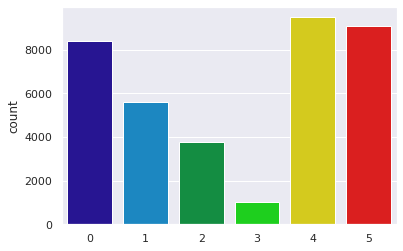

In [102]:
X_saved.shape, y_saved.shape

_ = sns.countplot(y_saved)

In [103]:
dtrain = xgb.DMatrix(data=train_features, label=train_label)
dtest = xgb.DMatrix(data=test_features)

In [104]:
params = {
    'max_depth': 9,
    'min_child_weight': 1,
    'n_estimators': 100,
    'subsample': 0.45,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 6,
    # Set number of GPUs if available   
    'n_gpus': 0
}



In [105]:
bst = xgb.train(params, dtrain)

In [106]:
pred = bst.predict(dtest)

In [107]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1684
           1       1.00      0.96      0.98      1123
           2       1.00      1.00      1.00       755
           3       0.95      0.66      0.78       204
           4       0.82      0.84      0.83      1900
           5       0.76      0.79      0.78      1416

    accuracy                           0.90      7082
   macro avg       0.92      0.87      0.89      7082
weighted avg       0.90      0.90      0.90      7082



In [108]:
cm = confusion_matrix(y_test, pred)
cm

array([[1645,    0,    0,    0,   19,   20],
       [   3, 1082,    0,    5,   19,   14],
       [   0,    0,  755,    0,    0,    0],
       [  20,    5,    0,  134,   26,   19],
       [   0,    0,    0,    0, 1604,  296],
       [   9,    0,    0,    2,  280, 1125]])

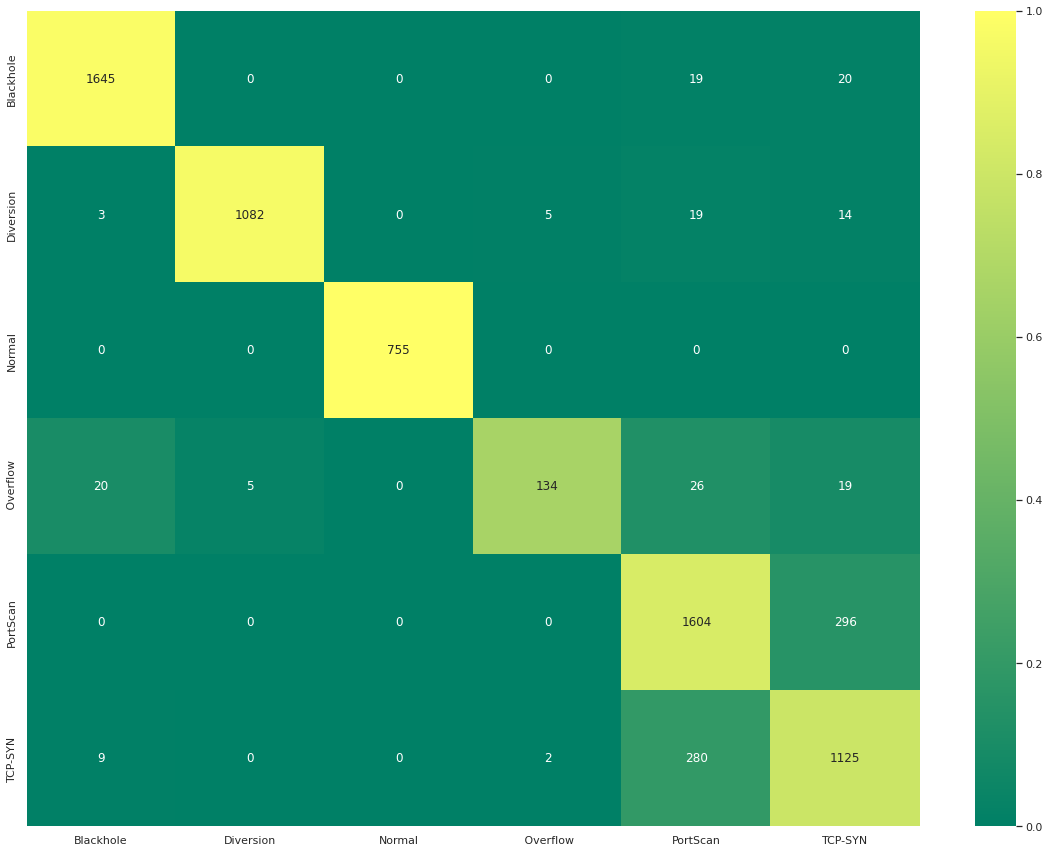

In [109]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='summer'):
    plt.figure(figsize=[20, 15])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, ['Blackhole', 'Diversion', 'Normal', ' Overflow',  'PortScan',  'TCP-SYN'])

### Explainability of our model using Lime on tabular data

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 28.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cfe02bdd84a885d7163ce50569e44e448de195fd856c97f6bc7266e0e94b38bf
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular
 
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_features),
    feature_names=train_features.columns,
    class_names=['Blackhole', 'Diversion', 'Normal', ' Overflow',  'PortScan',  'TCP-SYN'],
    mode='classification'
)

In [110]:
# def predict_proba(arr):
#     pred = bst.predict(test_features)
#     r = []
#     for i in pred:
#         temp = i[0]
#         r.append(np.array([1-temp,temp])) 
#     return np.array(r)

In [111]:
# exp = explainer.explain_instance(
#     train_features.iloc[1], 
#     predict_fn = predict_proba,
#     num_features=6)
# exp.show_in_notebook(train_features.iloc[1])

In [112]:
# exp = explainer.explain_instance(
#     data_row=test_features.iloc[1], 
#     predict_fn=predict_proba)


# exp.show_in_notebook(show_table=True)

## Deep learning for NTMA (Networks Traffic Monitoring)

- DL models do not require considerable human effort and they are not dependent on the choice of features. DL models can employ different representative layers and efficient algorithms to extract hidden knowledge from massive amounts of traffic data without feature engineering. This advantage of the DL models is very efficient for NTMA techniques as most of the network management data is unlabeled or semi-labeled.

- Source: https://www.sciencedirect.com/science/article/pii/S0140366421000426

***5.1. DL for traffic classification***

-In its broadest definition, network traffic classification refers to a system in which a program assigns traffic flows to the sources (e.g., applications and protocols) that produce them. Traffic classification has attracted ever-increasing interest over the years as a crucial step towards the network management process. Moreover, traffic classification covers a wide variety of applications in QoS purposes, pricing in Internet service providers (ISPs), anomaly detection, etc. Due to the continuing growth in Internet-based applications and the number of connected devices, applying efficient traffic classification methods is critically important. Generally speaking, one can categorize network traffic classification techniques into three basic classes as listed below [80]:

- **port-based:** These techniques simply associate services/applications to registered port numbers, e.g. HTTP port, and categorize the traffic according to the used port number. Port-based techniques are among the earliest traffic classification methods. Despite the advantages of port-based techniques such as simplicity on implementation, deploying new communication methods such as tunneling and random ports assignments techniques cause serious difficulties and affect the performance and applicability of them.

- **payload-based:** Payload-based methods, also known DPI, closely investigate the content of the captured packet, especially the application layer-related information, in order to associate the packet to a specific service/application. In order to make a prediction, this methodology usually leverages predefined signatures or patterns for each communication protocol, and then discover these patterns to differentiate the traffic flows from each other. Payload-based classification techniques suffer from three main problems in conventional networking paradigms as listed below:

1. They run into difficulties with encrypted traffic classification.
2. Privacy policies may limit access to the contents of the packets.
3. Payload methods impose heavy computational overhead on communication systems

As a result of these difficulties, new traffic classification methods have been proposed to dispose the need for inspecting packets contents.

- **Flow-based:** The underlying assumption behind the flow-based methods is that traffic associated with each application/service has almost unique statistical/time series characteristics. Hence, a flow-based classifier can handle both encrypted and normal traffic. Flow-based methods generally use traditional ML models, such as decision tree, logistic regression, and Support Vector Machine (SVM) for traffic classification. Despite this fact that ML models achieve a remarkable accuracy level, they need a massive amount of fully labeled data for modeling purposes.


With the rapid increase in the number of DL models, researchers have recently investigated these models for traffic classification and consequently reported great accuracy [49]. Motivated by the DL models proliferation, we provided a comprehensive review of traffic classification works.

Due to the complexity and low accuracy of MLP networks, pure MLP implementation has rarely been employed for network traffic classification. Pure MLP suffers from the disadvantages that it needs to tune some hyper-parameters, such as the number of hidden neurons and layers and sensitivity to feature scaling. A combination of MLP with other DL methods and pure MLP has been studied in some works, including in [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92].

**Aceto et al. [81] studied DL-based models for mobile traffic classification. They reproduced several DL classifiers, e.g., MLP, LSTM, CNN, and SAE, from the traffic classification literature in order to make a comprehensive evaluation for showing the accuracy of these classifiers. Among DL-based classifiers, the best performance is related to 1D-CNN with 76.37%/85.70% accuracy and the F-measure of 75.56%/78.78% on FB-FBM and Android dataset, respectively. The authors acknowledge the fact that classical ML algorithms that employ experts- and manually-based methods for feature extraction are not appropriate for modern networks due to: (1) handheld devices’ massive deployment, such as smartphones and tablets, considerably increases mobile traffic volume, (2) the massive adoption of the encrypted network protocols, e.g., Transport Layer Security (TLS), reduces the effectiveness of DPI techniques based on ML algorithms, and (3) considering the ever-increasing development of mobile applications and the changing nature of mobile traffic, implementing up-to-date and accurate traffic classifiers through classical ML algorithms is challenging.**

Wang et al. [82] also developed different DL-based traffic classifiers. Motivated by the recent advances in DL-based traffic classification and the weaknesses of the available traffic classification techniques, e.g., DPI, in giving real-time application awareness for encrypted network traffic, the authors used DL-based models, i.e., MLP, SAE, and CNN, to categorize traffic in the smart home use case. They used an open dataset with 200,000 encrypted data points from 15 applications to evaluate the models. The experimental results reveal the applicability of the evaluated models for smart home networks. More specifically, the average results of Precision, Recall and F1-Score on DataNet dataset are MLP  0.9657%, 0.9653%, and 0.9653%, SAE  0.9883% 0.9881%, and 0.9882%, CNN  0.9847%, 0.9842%, and 0.9843%, respectively. The authors of [83] focused on media traffic classification through DL. They applied CNN and MLP methods to classify four types of media traffic, i.e., video, audio, image, and text. According to the results, MLP shows good performance in terms of accuracy (0.9983%) and training time (0.019 s) under different scenarios.

In [84], IDS is considered by Ferreira and Shinoda since intrusion detection is a serious challenge in the context of NTMA. The authors introduced a new intrusion detection dataset and employed several traffic classification algorithms, such as MLP, J48, and Bayesian networks, to evaluate the dataset. Similarly, works in [85], [86], [87], [88], [89], [90], [91], [92] proposed to use an MLP for traffic classification in IDS.

Despite difficulties with using pure MLP, some works use this model for traffic classification. For example, in [90], Miller et al. used MLP to categorize encrypted VPN and non-VPN network traffic. The simulation results show 92% and 93% accuracy for VPN and non-VPN traffic classifiers, respectively. Similarly, Sahay et al. deployed MLP neural networks as a classification tool to detect misappropriation attacks in Low power and Lossy Networks (LLNs) [91]. The authors claim that the proposed method can also find the nodes affected by the attack and determine the malicious nodes. The pure MLP model has also been adopted in the context of IDS. Wang et al. used the MLP network in combination with the sequential feature selection technique in order to detect distributed denial of service (DDoS) attack [92]. They utilized these techniques to select the optimal features during the training phase. Moreover, to show the effectiveness of the proposed methodology ( accuracy), they compared it with some papers in the literature.

As mentioned, one of the main advantages of CNNs compared to conventional neural networks is the automatic detection of the important features and hierarchical feature extraction. A simple CNN model proposed in [93] for the categorization of encrypted traffic. This paper is one of the first works leveraging CNNs in the context of traffic classification, in which encrypted traffic is transformed into two-dimensional images, and then the images fed into the CNN model to be classified. The authors reported an accuracy of 1D-CNN  1%, 82%, 98%, and 86%, and 2D-CNN  1%, 80%, 97%, and 84% for four different experiments, respectively. The main advantages of the method presented in this work over the existing traffic classifiers, such as classical ML classifiers, include (1) integrating feature extraction/selection/classification phases into an end-to-end framework; (2) categorization of the encrypted network traffic which is a challenging task for the traditional classifiers. In [94], the authors also adopted the CNN model for IP traffic classification. They converted sequences into images that fully represent the patterns of different applications, such as Facebook and Instagram. Then, the CNN model is employed to classify the images to different applications. Rezaei and Liu proposed a one-dimensional CNN-based semi-supervised approach to categorize five Google applications [95]. To reduce the need for large labeled traffic datasets, first, the model is pre-trained on a big unlabeled training test where the time series characteristics of a few samples of packets are considered as the input. The proposed method’s performance is evaluated with different sampling techniques (i.e., fixed step sampling, random sampling, and incremental sampling) on three different datasets, including the QUIC dataset, Unlabeled Waikato dataset, and Ariel dataset. The proposed pre-trained method achieved higher accuracy than its non-pre-trained counterpart, with 81.50%, 81.27%, and 80.76% on the QUIC dataset for the sampling techniques. As mentioned, the authors use a 1D-CNN as a classifier because they believe the using of new applications and network encryption techniques have considerably raised the complexity of the traffic classification tasks, mainly when one uses classical ML-based methods.

In [96], a novel IDS, namely, HAST-IDS, is proposed, in which CNN and LSTM models are used to learn the low-level features of spatial information of network traffic and high-level features of temporal information, respectively. No feature engineering phase is used in the proposed system since the deep neural models automatically learn the key features. To measure the effectiveness of the system, DARPA1998 and ISCX2012 datasets have been used by the authors, where HAST-IDS outperformed its competitions in terms of training and testing time and accuracy in both datasets. For example, in the DARPA1998 dataset, the training and testing time is 58 min and 1.7 min, respectively, and accuracy on the ISCX2012 dataset is . Yeo et al. [97] applied CNN to malware detection tasks in an automated fashion. The authors claim that the introduced method can detect malware that uses unpredictable port numbers and protocols. This is mainly due to the fact that the model employs 35 different features captured from the packet flow, instead of features extracted from packets such as the port numbers and protocols. Besides, conventional networks have been used as traffic classifiers in IoT networks, where traffic classification can help distinguish between traffic/behavior of heterogeneous devices and services in these networks [98]. In this work, the authors combined CNN and RNN models to achieve the best detection results, around 97% accuracy when they use all features. The proposed method shows excellent performance in terms of detection scores, even under a highly unbalanced dataset. Compared to the classical ML techniques, the proposed DL models in [98] do not need to go through the feature engineering phase thanks to the convolutional layers that extract complex features automatically from the input data.

Tong et al. [99] provided the novel traffic classification based on CNN to categorize QUIC protocol traffic. They focus on the networks that use Google’s QUIC protocol since the traffic generated by such systems imposes several challenges for traffic classification tasks because this protocol decreases network traffic visibility. As a result, port- and payload-based traffic classification methods cannot be used for QUIC-based communications. To deal with this problem, CNN has been proposed, utilizing the flow- and packet-based features for further improvement. CNNs have also been adopted for malware traffic classification [100]. In this work, first, the network traffic is transformed into two-dimensional images. The convolutional network is then used to classify these images into different categories, such as Skype, FTP, and Outlook, , and the authors reported the average accuracy of 99.41%. Despite the advantages of the proposed method, the authors highlighted some limitations of their work, including (1) the size of the used dataset and classes number are fixed, while in the real-world use cases is not undoubtedly true, (2) the proposed method only utilized network traffic spatial features, while classical ML-based classification methods utilize different temporal features and show high accuracy.

For network traffic classification, RNN models are usually used with other DL models. For instance, in [98], both the RNN and CNN models are used for traffic classification. Different DL models are implemented in this work, where a particular combination of CNN/RNN achieved the highest degree of accuracy. Radford et al. proposed a creative method in [101] for network anomaly detection through RNN. They converted network flow into sequences of words that form sentences, then these sentences are considered as the language model of a specific network. RNN is used to identify network activities that are malicious with respect to the model.

Auto-encoders are mainly used as an unsupervised technique to do automatic feature extraction and selection. More specifically, the output of the encoding part of an AE network can be used as a high-level set of discriminative features for a classification problem. Auto-encoders models have also been applied to classification problems, e.g., in [49] Lotfollahi et al. adopted an Stacked Autoencoders (SAE) model, called Deep Packet, for encrypted traffic classification. The SAE stacks several AEs to form a deep structure to obtain a better performance. The authors used the UNB ISCX VPN-nonVPN dataset to assess the performance of the introduced method. Deep Packet outperformed all of the introduced and compared classification methods on the used dataset, including two classical ML algorithms, i.e., k-NN and C4.5, an accuracy of 0.98% is compared to 0.94% and 0.90%, respectively. Moreover, given the increasing interactions between different components on the Internet and, consequently, the network’s considerable complexity and diversity, DL algorithms are necessary to perform traffic classification tasks. In [102], Zhao et al. deployed AE to extract and aggregate features from traffic data. Then, they used the n-gram embedding strategy and k-means clustering to classify unknown traffic, i.e., network traffic generated by previously unknown applications or services. The authors have targeted network flow classification in [103]. They proposed an improved SAE, in which several basic Bayesian auto-encoders are stacked to understand the complex relations between the multi-source network flows. Moreover, the proposed SAE is trained through the back-propagation learning algorithm and in a supervised learning manner in order to learn the complex relations between the network flows. The simulation results show the improved SAE outperforms its ancestor in terms of accuracy (83.2 percent accuracy versus 82.9 percent). Last but not least, in [104] a comparison between the classical machine learning classification method and the DL method, i.e., SAE, has been made. The experiments revealed that DL model provides better accuracy (with 99.20%) than the classical ML model (with 95.22%). Furthermore, the authors claimed that in highly distributed networks, such as IoT systems, the traditional techniques such as classical ML techniques for NTMA purposes (e.g., attack detection) have less scalability. As a result, they proposed edge-based deep learning to deal with modern communication systems’ distributed and complex nature. The vast amount of data generated by IoT edge devices allow DL models to learn more useful than classical ML models.

In the context of network traffic classification, deep generative models can be used to deal with the imbalanced dataset problem. An imbalanced dataset refers to the situation in which the number of instances available for different data classes is considerably different. In such situations, predicting the classes with few instances is usually challenging for classical ML models. To alleviate this problem, oversampling and undersampling are two frequent and easy techniques. In the former, oversampling can be realized through duplicating instances of minor label classes, whereas by deleting some instances from major classes, one can implement an undersampling technique. In [105], a deep generative model, namely Auxiliary Classifier GANs (AC-GAN), is proposed to address the problem of imbalanced classes of network data. More precisely, Generative Adversarial Network (GAN) has been deployed for the generation of synthesized data instances to create a balance between the minor and the major label classes. In [106], Alom et al. used Deep Belief Neural Network (DBNN), a well known generative model, for intrusion detection. Furthermore, they compared the proposed method with some existing methods, such as SVM and DBNN-SBM. The proposed methods outperformed all these methods in terms of classification accuracy by achieving  accuracy. The authors announced that their method is not only able to detect threats, but also categorize them in five classes with the accuracy of detection. Another advantage of the provided DL model is that it can detect any unknown attack that has not been considered in the training dataset. Iliyasu et al. introduced a semi-supervised learning technique by Deep Convolutional Generative Adversarial Network (DCGAN) for the classification of encrypted network traffic [107]. The main idea behind this method is to use DCGAN for instance generation, as well as utilizing unlabeled traffic data to increase the accuracy of the learner, even when a small number of labeled data is available for training purposes. The authors deployed QUIC and ISCX VPN-NonVPN datasets to demonstrate the accuracy of their model, where the model delivered 89% and 78% classification accuracy on both QUIC and ISCX VPN-NonVPN datasets, respectively. As another positive point, the proposed deep method can alleviate the problems connected with extensive dataset collecting and labeling, which are problematic for both classical ML and DL models.


* K-means

Deep Packet outperformed all of the introduced and compared classification methods on the used dataset, including two classical ML algorithms, i.e., k-NN and C4.5, an accuracy of 0.98% is compared to 0.94% and 0.90%, respectively. Moreover, given the increasing interactions between different components on the Internet and, consequently, the network’s considerable complexity and diversity, DL algorithms are necessary to perform traffic classification tasks. In [102], Zhao et al. deployed AE to extract and aggregate features from traffic data. Then, they used the n-gram embedding strategy and k-means clustering to classify unknown traffic, i.e., network traffic generated by previously unknown applications or services. The authors have targeted network flow classification in [103]. They proposed an improved SAE, in which several basic Bayesian auto-encoders are stacked to understand the complex relations between the multi-source network flows


* DL vs. ML

The experiments revealed that DL model provides better accuracy (with 99.20%) than the classical ML model (with 95.22%). Furthermore, the authors claimed that in highly distributed networks, such as IoT systems, the traditional techniques such as classical ML techniques for NTMA purposes (e.g., attack detection) have less scalability. As a result, they proposed edge-based deep learning to deal with modern communication systems’ distributed and complex nature. The vast amount of data generated by IoT edge devices allow DL models to learn more useful than classical ML models.

* Unbalanced data set

In the context of network traffic classification, deep generative models can be used to deal with the imbalanced dataset problem. An imbalanced dataset refers to the situation in which the number of instances available for different data classes is considerably different. In such situations, predicting the classes with few instances is usually challenging for classical ML models. To alleviate this problem, oversampling and undersampling are two frequent and easy techniques. In the former, oversampling can be realized through duplicating instances of minor label classes, whereas by deleting some instances from major classes, one can implement an undersampling technique. In [105], a deep generative model, namely Auxiliary Classifier GANs (AC-GAN), is proposed to address the problem of imbalanced classes of network data. More precisely, Generative Adversarial Network (GAN) has been deployed for the generation of synthesized data instances to create a balance between the minor and the major label classes. In [106], Alom et al. used Deep Belief Neural Network (DBNN), a well known generative model, for intrusion detection.

* DeepInsight: A methodology to transform a non-image data to an image for convolution neural
network architecture

- It is critical, but difcult, to catch the small variation in genomic or other kinds of data that diferentiates phenotypes or categories. A plethora of data is available, but the information from its genes or elements is spread over arbitrarily, making it challenging to extract relevant details for identifcation.

- However, an arrangement of similar genes into clusters makes these diferences more accessible and
allows for robust identifcation of hidden mechanisms (e.g. pathways) than dealing with elements individually. Here we propose, DeepInsight, which converts non-image samples into a well-organized image-form. Thereby, the power of convolution neural network (CNN), including GPU utilization, can be realized for non-image samples.

- Furthermore, DeepInsight enables feature extraction through the application of CNN for non-image samples to seize imperative information and shown promising results. To our knowledge, this is the frst work to apply CNN simultaneously on diferent kinds of nonimage datasets: RNA-seq, vowels, text, and artifcial


## DeepInsight Application


### ImageTransformer & Squeezenet using pytorch

In [ ]:
from pyDeepInsight import ImageTransformer, Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
random_state=1515

In [ ]:
from google.colab import files
upload = files.upload()

Saving UNR-IDD.csv to UNR-IDD (2).csv


In [ ]:
import pandas as pd
raw_df = pd.read_csv('UNR-IDD.csv')

In [ ]:
cleanned_df = raw_df[['Switch ID',
                     'Port Number',
                     'Received Packets',
                     'Received Bytes',
                     'Sent Bytes',
                     'Sent Packets',
                     'Port alive Duration (S)',
                     'Delta Received Packets',
                     'Delta Received Bytes',
                     'Delta Sent Bytes',
                     'Delta Sent Packets',
                     'Delta Port alive Duration (S)',
                     'Connection Point',
                     'Total Load/Rate',
                     'Total Load/Latest',
                    #  'Unknown Load/Rate',
                    #  'Unknown Load/Latest',
                    #  'Latest bytes counter',
                     'Active Flow Entries',
                     'Packets Looked Up',
                    #  'Packets Matched',
                     'Label',
                     'Binary Label']]

In [ ]:
df_start = cleanned_df.copy()

In [ ]:
df_start = cleanned_df.copy()

In [ ]:
df_deep = df_start.sample(100).copy()

In [ ]:
# Label encoding target feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_deep['Binary Label'] = le.fit_transform(df_deep['Binary Label'])

In [ ]:
df_deep['Binary Label'].value_counts()

0    92
1     8
Name: Binary Label, dtype: int64

In [ ]:
y = df_deep['Label'].values

In [ ]:
df_deep.drop(['Label'], axis=1, inplace=True)

In [ ]:
X = df_deep.iloc[:, 2:].values
network = df_deep.iloc[:, 2:].columns.to_numpy()

random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

In [ ]:
# Normalize data using LogScaler and encode classes
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Create t-SNE object

In [ ]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

Initialize image transformer.

In [ ]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

Train image transformer on training data and transform training 
and testing sets. Values should be between 0 and 1.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


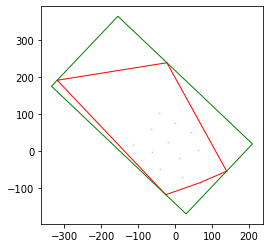

In [ ]:
it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

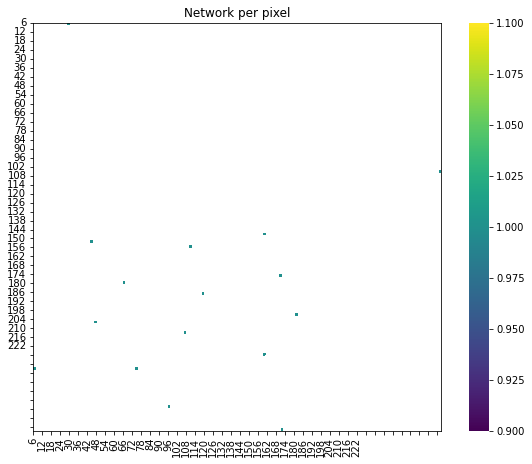

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Network per pixel")

The following are showing plots for the image matrices first four samples 
of the training set. 

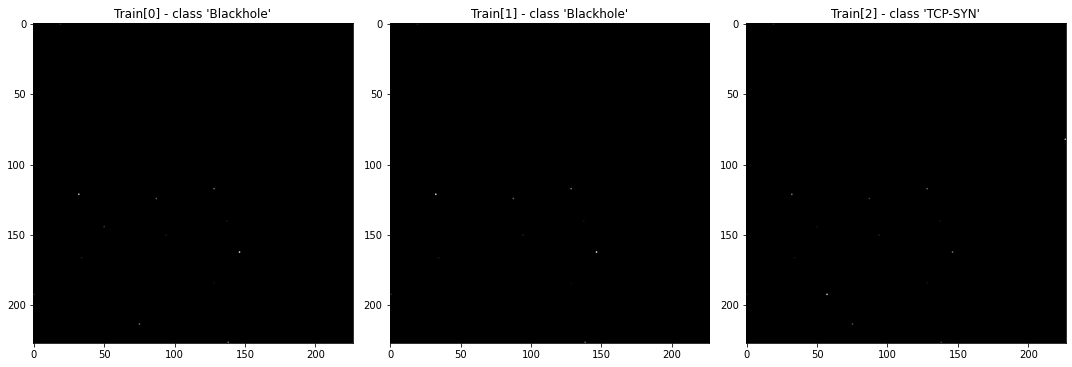

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

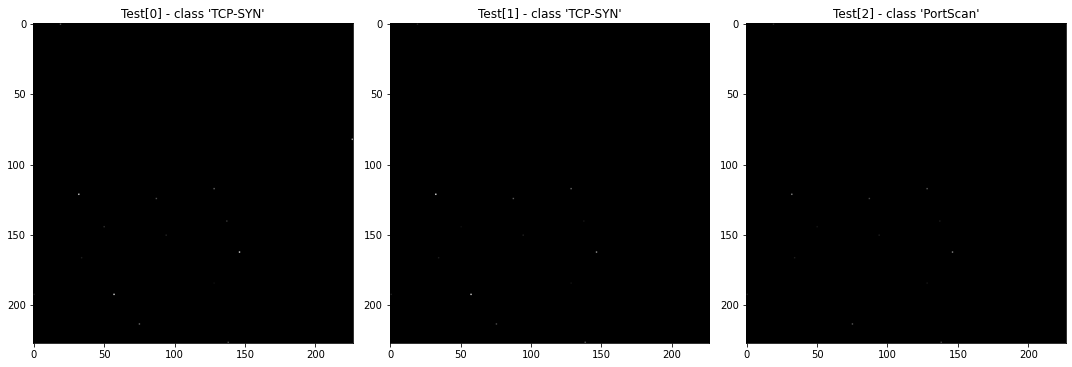

In [ ]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

### SqueezeNet

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score

import warnings; 
warnings.simplefilter('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Download [PyTrorch SqueezeNet 1.1][1] and modify output layer as 
to match number of labels as described in [Finetuning Torchvision Model][2].

[1]: https://pytorch.org/hub/pytorch_vision_squeezenet/
[2]: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
net = torch.hub.load(
    'pytorch/vision:v0.10.0', 'squeezenet1_1', 
    pretrained=True, verbose=False)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1))
net = net.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(le.fit_transform(y_train)).to(device)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(le.transform(y_test)).to(device)

Generate pyTorch datasets and dataloaders for training and testing sets.

In [ ]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-04,
    momentum=0.8,
    weight_decay=1e-05
)

Train SqueezeNet for 200 epochs

In [ ]:
for epoch in range(200):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

[0] loss: 4.307
[20] loss: 4.012
[40] loss: 3.927
[60] loss: 3.890
[80] loss: 3.948
[100] loss: 3.908
[120] loss: 3.816
[140] loss: 3.848
[160] loss: 3.769
[180] loss: 3.822
[199] loss: 3.751


Calculate accuracy of prediction

In [ ]:
train_predicted = np.empty(0)
train_true = np.empty(0)
with torch.no_grad():
    net.eval()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        train_predicted = np.append(train_predicted, pred)
        train_true = np.append(train_true, labels.cpu().detach().numpy())

In [ ]:
test_predicted = np.empty(0)
test_true = np.empty(0)
with torch.no_grad():
    net.eval()
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

In [ ]:
print(f"The train accuracy was {accuracy_score(train_predicted, train_true):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The train accuracy was 0.475
The test accuracy was 0.500


# New Section

# New Section